In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = 'No willr LSTM Time Series - cyclic'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from sklearn import preprocessing

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Cyclic Stocks

### Singapore Airlines

In [5]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14      OBV_7  labels
0  2000-01-21    19.000000  19.215335 -37.499990   388000.0     2.0
1  2000-01-24    18.400000  19.089899 -50.000000 -2311000.0     2.0
2  2000-01-25    18.100000  18.937607 -48.780483 -3542000.0     2.0
3  2000-01-26    17.700001  18.747206 -85.714237 -6261000.0     2.0
4  2000-01-27    17.799999  18.601482 -82.142864 -4565000.0     2.0


In [6]:
df.set_index('Date', inplace=True)

In [7]:
df.drop(['willr_14'], axis='columns', inplace=True)

In [8]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [9]:
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
X.shape

(4725, 15, 3)

In [10]:
v = X.reshape(X.shape[0],15, 3)
v[0]

array([[1.        , 1.        , 1.        ],
       [0.75999985, 0.92783951, 0.79689969],
       [0.64000015, 0.8402295 , 0.70426669],
       [0.48000031, 0.73069638, 0.49966137],
       [0.51999969, 0.64686477, 0.62728573],
       [0.6       , 0.59363121, 0.70140718],
       [0.71999969, 0.57513856, 0.83332079],
       [0.51999969, 0.51523893, 0.71510272],
       [0.48000031, 0.45570436, 0.64782903],
       [0.55999985, 0.42302965, 0.70140718],
       [0.35999985, 0.35112982, 0.54255399],
       [0.4       , 0.29914193, 0.57822259],
       [0.15999985, 0.20204974, 0.41944465],
       [0.08000031, 0.1021941 , 0.18639476],
       [0.        , 0.        , 0.        ]])

In [11]:
y = labels
y = np.array(y)
y.shape

(4725,)

In [12]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [13]:
SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
RATIO_TO_PREDICT = "Close"

In [14]:
import time

EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [15]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [17]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 30ms/step - loss: 0.2957 - accuracy: 0.5161 - mse: 0.4613 - weighted_accuracy: 0.3248 - weighted_mse: 0.5424 - val_loss: 0.3007 - val_accuracy: 0.0455 - val_mse: 0.3513 - val_weighted_accuracy: 0.0455 - val_weighted_mse: 0.3513
Epoch 2/200
30/30 [==============================] - 0s 7ms/step - loss: 0.2117 - accuracy: 0.3415 - mse: 0.7727 - weighted_accuracy: 0.4276 - weighted_mse: 0.7886 - val_loss: 0.2907 - val_accuracy: 0.0455 - val_mse: 0.3791 - val_weighted_accuracy: 0.0455 - val_weighted_mse: 0.3791
Epoch 3/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1918 - accuracy: 0.2968 - mse: 1.0043 - weighted_accuracy: 0.4463 - weighted_mse: 1.0120 - val_loss: 0.2792 - val_accuracy: 0.0455 - val_mse: 0.4121 - val_weighted_accuracy: 0.0455 - val_weighted_mse: 0.4121
Epoch 4/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1850 - accuracy: 0.2669 - mse: 1.1339 - weighted_accuracy: 0.4723 - weighte

Epoch 30/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1444 - accuracy: 0.3638 - mse: 1.5953 - weighted_accuracy: 0.6797 - weighted_mse: 1.5127 - val_loss: 0.1895 - val_accuracy: 0.3386 - val_mse: 1.6045 - val_weighted_accuracy: 0.3386 - val_weighted_mse: 1.6045
Epoch 31/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1441 - accuracy: 0.3995 - mse: 1.5856 - weighted_accuracy: 0.6689 - weighted_mse: 1.5239 - val_loss: 0.2003 - val_accuracy: 0.2995 - val_mse: 1.6140 - val_weighted_accuracy: 0.2995 - val_weighted_mse: 1.6140
Epoch 32/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1430 - accuracy: 0.3553 - mse: 1.6429 - weighted_accuracy: 0.6767 - weighted_mse: 1.5601 - val_loss: 0.1862 - val_accuracy: 0.3831 - val_mse: 1.6008 - val_weighted_accuracy: 0.3831 - val_weighted_mse: 1.6008
Epoch 33/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1424 - accuracy: 0.4304 - mse: 1.6235 - weighted_accuracy: 0.6858 - weig

Epoch 59/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1238 - accuracy: 0.5085 - mse: 2.0104 - weighted_accuracy: 0.7606 - weighted_mse: 1.9849 - val_loss: 0.1774 - val_accuracy: 0.4836 - val_mse: 2.0042 - val_weighted_accuracy: 0.4836 - val_weighted_mse: 2.0042
Epoch 60/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1234 - accuracy: 0.5167 - mse: 1.9976 - weighted_accuracy: 0.7674 - weighted_mse: 1.9615 - val_loss: 0.1839 - val_accuracy: 0.4540 - val_mse: 2.0469 - val_weighted_accuracy: 0.4540 - val_weighted_mse: 2.0469
Epoch 61/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1240 - accuracy: 0.5220 - mse: 2.0272 - weighted_accuracy: 0.7582 - weighted_mse: 2.0043 - val_loss: 0.1818 - val_accuracy: 0.4656 - val_mse: 2.0005 - val_weighted_accuracy: 0.4656 - val_weighted_mse: 2.0005
Epoch 62/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1228 - accuracy: 0.4981 - mse: 2.0566 - weighted_accuracy: 0.7660 - weig

Epoch 88/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1087 - accuracy: 0.6212 - mse: 2.4948 - weighted_accuracy: 0.8242 - weighted_mse: 2.5110 - val_loss: 0.1795 - val_accuracy: 0.5143 - val_mse: 2.4622 - val_weighted_accuracy: 0.5143 - val_weighted_mse: 2.4622
Epoch 89/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1058 - accuracy: 0.6079 - mse: 2.4941 - weighted_accuracy: 0.8230 - weighted_mse: 2.5156 - val_loss: 0.1711 - val_accuracy: 0.5630 - val_mse: 2.4624 - val_weighted_accuracy: 0.5630 - val_weighted_mse: 2.4624
Epoch 90/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1065 - accuracy: 0.6156 - mse: 2.5045 - weighted_accuracy: 0.8166 - weighted_mse: 2.5360 - val_loss: 0.1871 - val_accuracy: 0.5291 - val_mse: 2.5477 - val_weighted_accuracy: 0.5291 - val_weighted_mse: 2.5477
Epoch 91/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1070 - accuracy: 0.6376 - mse: 2.5112 - weighted_accuracy: 0.8246 - weig

Epoch 117/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0951 - accuracy: 0.6923 - mse: 3.0679 - weighted_accuracy: 0.8448 - weighted_mse: 3.1470 - val_loss: 0.1783 - val_accuracy: 0.5672 - val_mse: 3.0992 - val_weighted_accuracy: 0.5672 - val_weighted_mse: 3.0992
Epoch 118/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0901 - accuracy: 0.6685 - mse: 3.0886 - weighted_accuracy: 0.8637 - weighted_mse: 3.1578 - val_loss: 0.1371 - val_accuracy: 0.7122 - val_mse: 3.1239 - val_weighted_accuracy: 0.7122 - val_weighted_mse: 3.1239
Epoch 119/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0913 - accuracy: 0.6878 - mse: 3.0752 - weighted_accuracy: 0.8597 - weighted_mse: 3.1439 - val_loss: 0.1814 - val_accuracy: 0.5608 - val_mse: 3.1047 - val_weighted_accuracy: 0.5608 - val_weighted_mse: 3.1047
Epoch 120/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0879 - accuracy: 0.6868 - mse: 3.1464 - weighted_accuracy: 0.8649 - 

Epoch 146/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0799 - accuracy: 0.7429 - mse: 3.8962 - weighted_accuracy: 0.8854 - weighted_mse: 3.9853 - val_loss: 0.1838 - val_accuracy: 0.6000 - val_mse: 3.8707 - val_weighted_accuracy: 0.6000 - val_weighted_mse: 3.8707
Epoch 147/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0758 - accuracy: 0.7328 - mse: 3.8757 - weighted_accuracy: 0.8947 - weighted_mse: 3.8860 - val_loss: 0.1658 - val_accuracy: 0.6656 - val_mse: 4.0704 - val_weighted_accuracy: 0.6656 - val_weighted_mse: 4.0704
Epoch 148/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0756 - accuracy: 0.7595 - mse: 3.9039 - weighted_accuracy: 0.8970 - weighted_mse: 3.9266 - val_loss: 0.1742 - val_accuracy: 0.6508 - val_mse: 4.1893 - val_weighted_accuracy: 0.6508 - val_weighted_mse: 4.1893
Epoch 149/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0760 - accuracy: 0.7399 - mse: 4.0406 - weighted_accuracy: 0.8863 - 

Epoch 175/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0649 - accuracy: 0.8019 - mse: 4.9916 - weighted_accuracy: 0.9089 - weighted_mse: 4.9130 - val_loss: 0.1755 - val_accuracy: 0.6804 - val_mse: 5.3264 - val_weighted_accuracy: 0.6804 - val_weighted_mse: 5.3264
Epoch 176/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0640 - accuracy: 0.7995 - mse: 5.0151 - weighted_accuracy: 0.9154 - weighted_mse: 4.9342 - val_loss: 0.1892 - val_accuracy: 0.6508 - val_mse: 4.9480 - val_weighted_accuracy: 0.6508 - val_weighted_mse: 4.9480
Epoch 177/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0634 - accuracy: 0.7981 - mse: 5.0653 - weighted_accuracy: 0.9149 - weighted_mse: 5.0056 - val_loss: 0.1897 - val_accuracy: 0.6370 - val_mse: 5.3234 - val_weighted_accuracy: 0.6370 - val_weighted_mse: 5.3234
Epoch 178/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0652 - accuracy: 0.7862 - mse: 5.1224 - weighted_accuracy: 0.9087 - 

In [18]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.20276978611946106
Test accuracy: 0.652910053730011


In [19]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.1428931  -3.0024064   0.40236494]
 [-2.818043   -0.51138043 -0.08491608]
 [-1.9294469  -1.651281    0.39518332]
 ...
 [-4.1433744  -3.550226    2.3955162 ]
 [-1.2754589  -4.8038616   0.7606225 ]
 [-4.088784   -0.7425534   0.5131265 ]]


Counter({2: 671, 0: 139, 1: 135})

In [20]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 859, 0: 43, 1: 43})

In [21]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 945
actual predicted buys: 9
actual buys but predicted sell: 2
actual buys but predicted hold: 32
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 37
actual holds but predicted buy: 126
actual holds but predicted sell: 131
actual predicted holds: 602
Percentage buys correct: 20.930232558139537%
Percentage sells correct: 13.953488372093023%
Percentage holds correct: 70.081490104773%
actual buys: 43
actual sells: 43
actual holds: 859


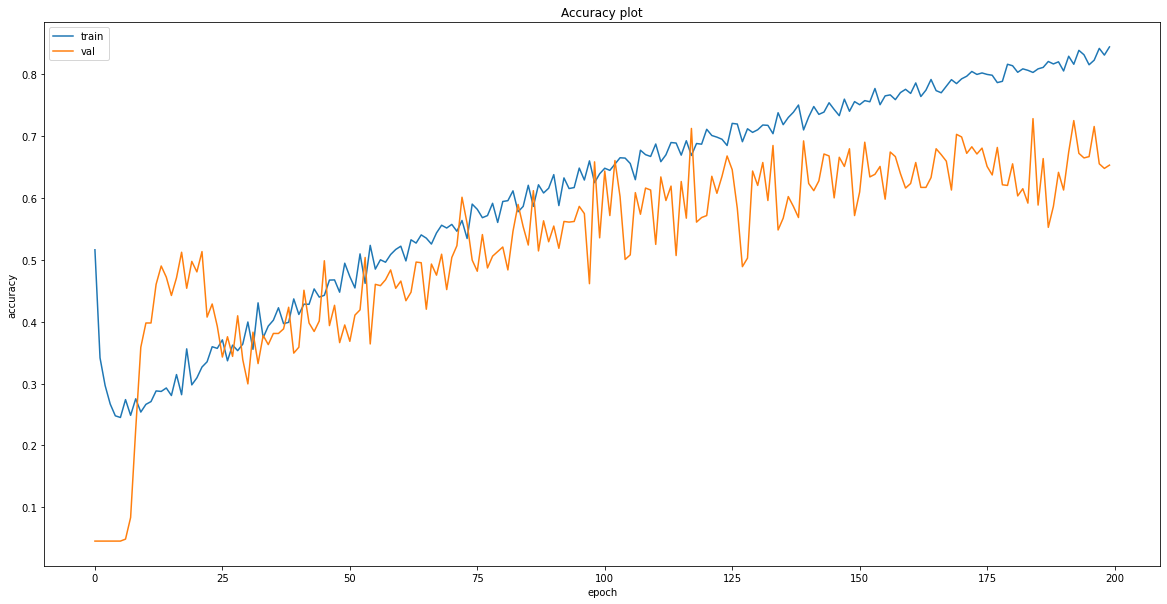

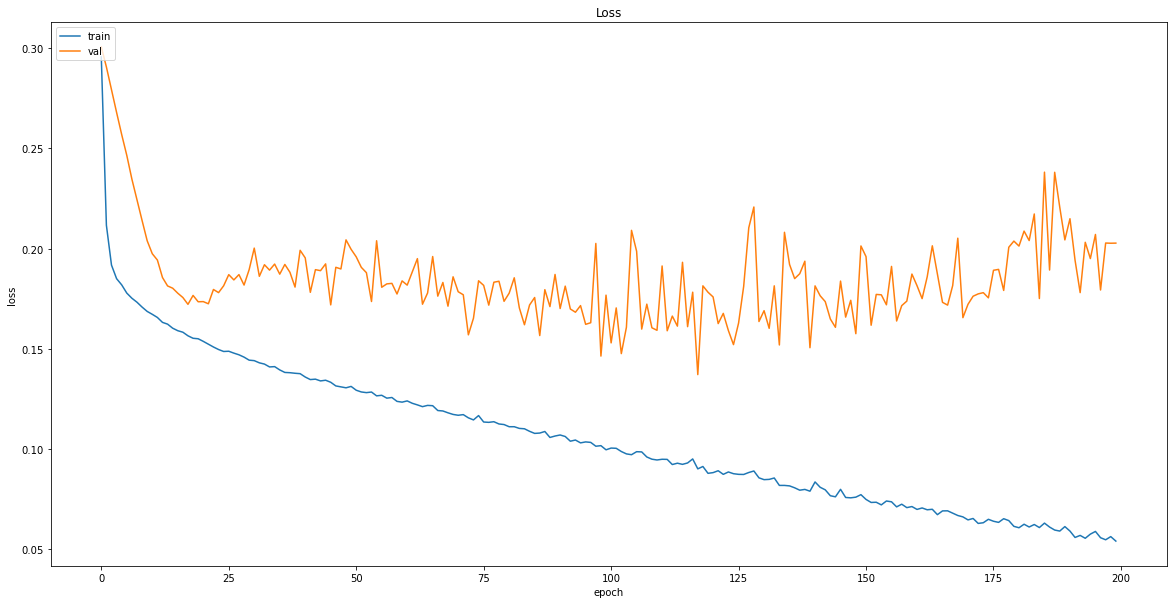

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [23]:
# Save model
model.save("models/{}".format('Singapore_Airlines_time_series_lstm_buy_hold_sell_no_willr.model'))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/Singapore_Airlines_time_series_lstm_buy_hold_sell_no_willr.model\assets


### Test Performance

### non-recession

In [24]:
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
log  = pd.DataFrame(columns = column_names)
logger = []

In [25]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2019-01-21         9.59  9.538960 -32.758553  6890900.0     2.0
2019-01-22         9.63  9.552966 -25.862007  7759500.0     2.0
2019-01-23         9.61  9.561740 -29.310362  7108100.0     1.0
2019-01-24         9.50  9.552242 -48.275822  6126400.0     2.0
2019-01-25         9.74  9.581128  -8.888884  8160300.0     2.0


In [26]:
df.drop(['willr_14'], axis='columns', inplace=True)

In [27]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [28]:
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(218, 15, 3)

In [29]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [30]:
model = tf.keras.models.load_model("models/Singapore_Airlines_time_series_lstm_buy_hold_sell_no_willr.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1770 - accuracy: 0.6330 - mean_squared_error: 5.1933 - weighted_accuracy: 0.6330 - weighted_mean_squared_error: 5.1933
Test loss: 0.17697231471538544
Test accuracy: 0.6330274939537048


In [31]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 142, 0: 38, 1: 38})

In [32]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 200, 0: 9, 1: 9})

In [33]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data_test.csv")
df.set_index('Date', inplace=True)

In [34]:
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df = df.iloc[13:]
df['predictions'] = predictions
df['actual'] = actual
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-08,9.76,9.644474,-45.454598,5084100.0,2.0,2,2
2019-02-11,9.71,9.662247,-15.151533,6464788.0,2.0,2,2
2019-02-12,9.65,9.669594,-30.303065,5675088.0,2.0,2,2
2019-02-13,9.73,9.666579,-48.484962,4337188.0,2.0,2,2
2019-02-14,9.87,9.676336,-32.000351,5826588.0,2.0,2,2


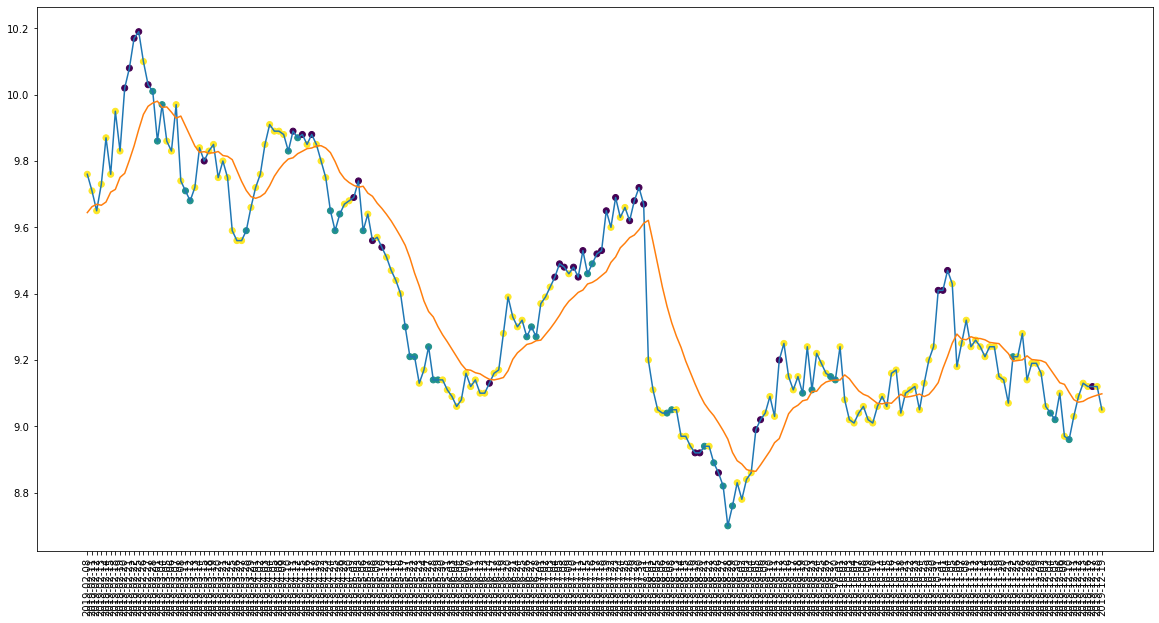

In [35]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [36]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 5
actual holds but predicted buy: 35
actual holds but predicted sell: 34
actual predicted holds: 131
Percentage buys correct: 33.333333333333336%
Percentage sells correct: 44.44444444444444%
Percentage holds correct: 65.5%
actual buys: 9
actual sells: 9
actual holds: 200


In [37]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[9.649999618530273, 9.710000038146973, 9.729999542236328, 9.760000228881836, 9.760000228881836, 9.829999923706056, 9.869999885559082, 9.949999809265137, 10.020000457763672]
[9.829999923706056, 9.949999809265137, 10.010000228881836, 10.020000457763672, 10.029999732971193, 10.079999923706056, 10.100000381469727, 10.170000076293944, 10.1899995803833]
Percentage buys correct: 73.6842105263158%
Percentage sells correct: 60.526315789473685%
Percentage holds correct: 81.69014084507042%


In [38]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $10.010000228881836
Shares owned at the moment: 996
Cash capital at the moment: $2.622381406783461


Stop Loss Activated!

Share price: $9.710000038146973
Shares owned at the moment: 0
Cash capital at the moment: $9647.186729296684


Share price: $9.710000038146973
Shares owned at the moment: 990
Cash capital at the moment: $7.851216427325198


Stop Loss Activated!

Share price: $9.4399995803833
Shares owned at the moment: 0
Cash capital at the moment: $9327.750402149199


Share price: $9.300000190734863
Shares owned at the moment: 1000
Cash capital at the moment: $2.1752108898144797


Stop Loss Activated!

Share price: $9.039999961853027
Shares owned at the moment: 0
Cash capital at the moment: $9017.315172847746


Share price: $9.039999961853027
Shares owned at the moment: 994
Cash capital at the moment: $6.844370870110652


Stop Loss Activated!

Share price: $8.699999809265138
Shares owned at the moment: 0
Cash capital at the moment: $8630.862731801031


Share price: $8

In [39]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $9222.27618237376
profit gained: -7.777238176262399%


In [40]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.633027,33.333333333333336%,44.44444444444444%,65.5%,73.6842105263158%,60.526315789473685%,81.69014084507042%,-10.226340083160448%,-7.777238176262399%


### Recession

In [41]:
logger = []

In [42]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2020-01-22         8.84  8.979182 -96.551645  -851200.0     2.0
2020-01-23         8.93  8.971615 -65.517105  1644900.0     2.0
2020-01-24         8.85  8.952905 -92.307523  -246900.0     2.0
2020-01-28         8.82  8.932458 -75.000000 -1718200.0     2.0
2020-01-29         8.56  8.875157 -86.885115 -5499900.0     2.0


In [43]:
df.drop(['willr_14'], axis='columns', inplace=True)

In [44]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [45]:
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(215, 15, 3)

In [46]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [47]:
model = tf.keras.models.load_model("models/Singapore_Airlines_time_series_lstm_buy_hold_sell_no_willr.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1845 - accuracy: 0.6465 - mean_squared_error: 5.5866 - weighted_accuracy: 0.6465 - weighted_mean_squared_error: 5.5866
Test loss: 0.1844877153635025
Test accuracy: 0.6465116143226624


In [48]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 149, 1: 37, 0: 29})

In [49]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [50]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data_test2.csv")
df.set_index('Date', inplace=True)

In [51]:
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df = df.iloc[13:]
df['predictions'] = predictions
df['actual'] = actual
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,8.53,8.641035,-89.830440,-3476200.0,2.0,2,2
2020-02-12,8.64,8.623953,-86.440694,-2356000.0,2.0,2,2
2020-02-13,8.59,8.626421,-61.224363,-575600.0,2.0,2,2
2020-02-14,8.62,8.620818,-64.102508,-2132700.0,2.0,2,2
2020-02-17,8.66,8.620692,-45.161340,-798700.0,2.0,2,2


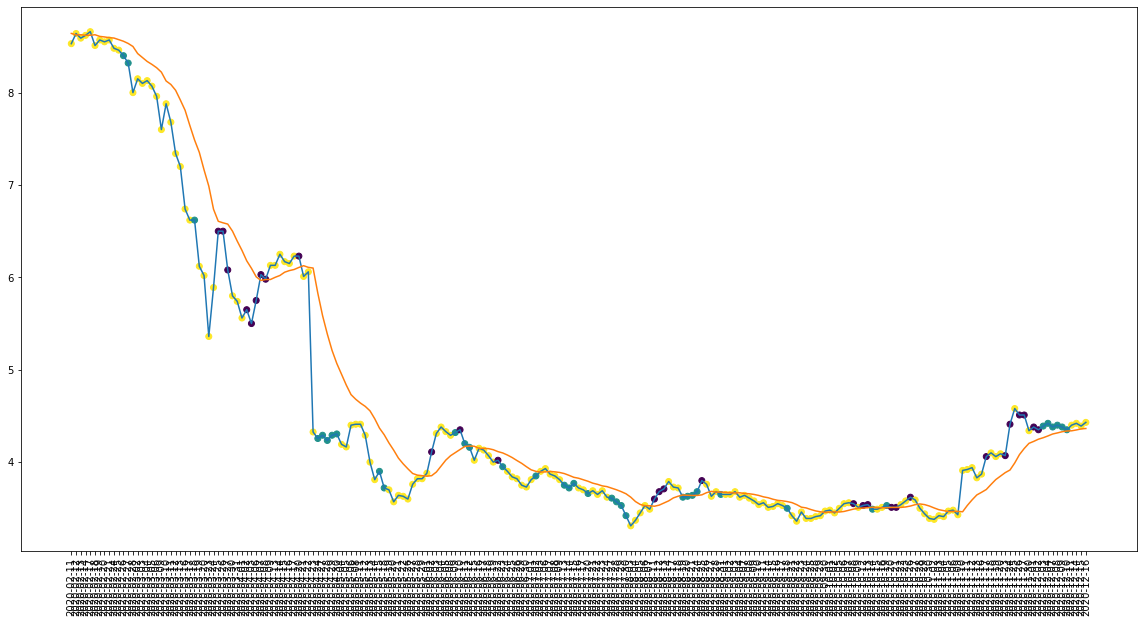

In [52]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [53]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 215
actual predicted buys: 1
actual buys but predicted sell: 2
actual buys but predicted hold: 5
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 7
actual holds but predicted buy: 35
actual holds but predicted sell: 26
actual predicted holds: 137
Percentage buys correct: 12.5%
Percentage sells correct: 11.11111111111111%
Percentage holds correct: 69.1919191919192%
actual buys: 8
actual sells: 9
actual holds: 198


In [54]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[8.510000228881836, 8.529999732971191, 8.550000190734862, 8.569999694824219, 8.569999694824219, 8.590000152587889, 8.619999885559082, 8.640000343322754, 8.659999847412111]
[8.0, 8.149999618530272, 8.319999694824219, 8.399999618530272, 8.460000038146973, 8.479999542236326, 8.550000190734862, 8.569999694824219, 8.569999694824219]
Percentage buys correct: 40.54054054054054%
Percentage sells correct: 55.172413793103445%
Percentage holds correct: 85.23489932885906%


In [55]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $8.399999618530272
Shares owned at the moment: 1187
Cash capital at the moment: $1.7807540497797163


Stop Loss Activated!

Share price: $8.0
Shares owned at the moment: 0
Cash capital at the moment: $9471.66675404978


Share price: $6.619999885559082
Shares owned at the moment: 1426
Cash capital at the moment: $5.586587691308523


Stop Loss Activated!

Share price: $6.119999885559082
Shares owned at the moment: 0
Cash capital at the moment: $8708.706844947339


Share price: $4.255593776702882
Shares owned at the moment: 2040
Cash capital at the moment: $3.4216593861565343


Stop Loss Activated!

Share price: $4.0
Shares owned at the moment: 0
Cash capital at the moment: $8140.981659386156


Share price: $3.9000000953674316
Shares owned at the moment: 2081
Cash capital at the moment: $2.7627353807665713


Stop Loss Activated!

Share price: $3.7200000286102295
Shares owned at the moment: 0
Cash capital at the moment: $7722.794164754925


Share price: $3.7200000286102295
Sha

In [56]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $5165.4369528948055
profit gained: -48.34563047105195%


In [57]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.633027,33.333333333333336%,44.44444444444444%,65.5%,73.6842105263158%,60.526315789473685%,81.69014084507042%,-10.226340083160448%,-7.777238176262399%
1,0.646512,12.5%,11.11111111111111%,69.1919191919192%,40.54054054054054%,55.172413793103445%,85.23489932885906%,-50.75888178490704%,-48.34563047105195%


### OCBC Bank

In [58]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14      OBV_7  labels
0  2000-01-21     6.793788  7.018572 -90.000010 -1965914.0     2.0
1  2000-01-24     6.890842  6.998922 -77.777802  6276910.0     2.0
2  2000-01-25     6.793788  6.967363 -85.714286  -511055.0     2.0
3  2000-01-26     6.745261  6.933193 -86.666549 -7435027.0     2.0
4  2000-01-27     6.890842  6.926678 -66.666601 -3725757.0     2.0


In [59]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,6.793788,7.018572,-90.000010,-1965914.0,2.0
2000-01-24,6.890842,6.998922,-77.777802,6276910.0,2.0
2000-01-25,6.793788,6.967363,-85.714286,-511055.0,2.0
2000-01-26,6.745261,6.933193,-86.666549,-7435027.0,2.0
2000-01-27,6.890842,6.926678,-66.666601,-3725757.0,2.0


In [60]:
df.drop(['willr_14'], axis='columns', inplace=True)

In [61]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [62]:
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
X.shape

(4789, 15, 3)

In [63]:
y = labels
y = np.array(y)

In [64]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [65]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [66]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [67]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [68]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 29ms/step - loss: 0.2846 - accuracy: 0.5466 - mse: 0.4705 - weighted_accuracy: 0.3670 - weighted_mse: 0.5520 - val_loss: 0.3005 - val_accuracy: 0.0418 - val_mse: 0.3515 - val_weighted_accuracy: 0.0418 - val_weighted_mse: 0.3515
Epoch 2/200
30/30 [==============================] - 0s 7ms/step - loss: 0.2045 - accuracy: 0.3310 - mse: 0.8108 - weighted_accuracy: 0.4791 - weighted_mse: 0.7967 - val_loss: 0.2907 - val_accuracy: 0.0418 - val_mse: 0.3815 - val_weighted_accuracy: 0.0418 - val_weighted_mse: 0.3815
Epoch 3/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1859 - accuracy: 0.2600 - mse: 1.0400 - weighted_accuracy: 0.4927 - weighted_mse: 1.0065 - val_loss: 0.2791 - val_accuracy: 0.0418 - val_mse: 0.4182 - val_weighted_accuracy: 0.0418 - val_weighted_mse: 0.4182
Epoch 4/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1790 - accuracy: 0.2130 - mse: 1.1942 - weighted_accuracy: 0.5147 - weighte

Epoch 30/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1343 - accuracy: 0.3600 - mse: 1.7933 - weighted_accuracy: 0.6913 - weighted_mse: 1.7117 - val_loss: 0.1768 - val_accuracy: 0.4290 - val_mse: 1.7091 - val_weighted_accuracy: 0.4290 - val_weighted_mse: 1.7091
Epoch 31/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1340 - accuracy: 0.3968 - mse: 1.7925 - weighted_accuracy: 0.7141 - weighted_mse: 1.7297 - val_loss: 0.1852 - val_accuracy: 0.4061 - val_mse: 1.8514 - val_weighted_accuracy: 0.4061 - val_weighted_mse: 1.8514
Epoch 32/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1337 - accuracy: 0.4090 - mse: 1.7877 - weighted_accuracy: 0.7132 - weighted_mse: 1.7183 - val_loss: 0.2069 - val_accuracy: 0.3090 - val_mse: 1.8304 - val_weighted_accuracy: 0.3090 - val_weighted_mse: 1.8304
Epoch 33/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1335 - accuracy: 0.3965 - mse: 1.8119 - weighted_accuracy: 0.7122 - weig

Epoch 59/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1156 - accuracy: 0.5020 - mse: 2.2862 - weighted_accuracy: 0.7698 - weighted_mse: 2.2804 - val_loss: 0.1820 - val_accuracy: 0.4656 - val_mse: 2.3705 - val_weighted_accuracy: 0.4656 - val_weighted_mse: 2.3705
Epoch 60/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1146 - accuracy: 0.5301 - mse: 2.2703 - weighted_accuracy: 0.7875 - weighted_mse: 2.2856 - val_loss: 0.1686 - val_accuracy: 0.5136 - val_mse: 2.3307 - val_weighted_accuracy: 0.5136 - val_weighted_mse: 2.3307
Epoch 61/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1141 - accuracy: 0.5244 - mse: 2.3016 - weighted_accuracy: 0.7775 - weighted_mse: 2.3134 - val_loss: 0.1738 - val_accuracy: 0.5136 - val_mse: 2.2513 - val_weighted_accuracy: 0.5136 - val_weighted_mse: 2.2513
Epoch 62/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1130 - accuracy: 0.5369 - mse: 2.2926 - weighted_accuracy: 0.7786 - weig

Epoch 88/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0967 - accuracy: 0.6241 - mse: 2.8308 - weighted_accuracy: 0.8351 - weighted_mse: 2.9183 - val_loss: 0.1520 - val_accuracy: 0.6367 - val_mse: 2.8476 - val_weighted_accuracy: 0.6367 - val_weighted_mse: 2.8476
Epoch 89/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0960 - accuracy: 0.6309 - mse: 2.8767 - weighted_accuracy: 0.8446 - weighted_mse: 2.9937 - val_loss: 0.1887 - val_accuracy: 0.5010 - val_mse: 2.9684 - val_weighted_accuracy: 0.5010 - val_weighted_mse: 2.9684
Epoch 90/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0963 - accuracy: 0.6455 - mse: 2.9030 - weighted_accuracy: 0.8198 - weighted_mse: 3.0185 - val_loss: 0.1748 - val_accuracy: 0.5470 - val_mse: 3.0172 - val_weighted_accuracy: 0.5470 - val_weighted_mse: 3.0172
Epoch 91/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0950 - accuracy: 0.6197 - mse: 2.9463 - weighted_accuracy: 0.8371 - weig

Epoch 117/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0816 - accuracy: 0.7155 - mse: 3.5443 - weighted_accuracy: 0.8719 - weighted_mse: 3.6897 - val_loss: 0.1997 - val_accuracy: 0.5553 - val_mse: 3.8623 - val_weighted_accuracy: 0.5553 - val_weighted_mse: 3.8623
Epoch 118/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0802 - accuracy: 0.7270 - mse: 3.6258 - weighted_accuracy: 0.8797 - weighted_mse: 3.8078 - val_loss: 0.1998 - val_accuracy: 0.5177 - val_mse: 3.8563 - val_weighted_accuracy: 0.5177 - val_weighted_mse: 3.8563
Epoch 119/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0786 - accuracy: 0.7029 - mse: 3.6257 - weighted_accuracy: 0.8749 - weighted_mse: 3.7990 - val_loss: 0.1549 - val_accuracy: 0.6597 - val_mse: 3.8276 - val_weighted_accuracy: 0.6597 - val_weighted_mse: 3.8276
Epoch 120/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0800 - accuracy: 0.7400 - mse: 3.6570 - weighted_accuracy: 0.8848 - 

Epoch 146/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0662 - accuracy: 0.7773 - mse: 4.5605 - weighted_accuracy: 0.9059 - weighted_mse: 4.7241 - val_loss: 0.1630 - val_accuracy: 0.6921 - val_mse: 4.8359 - val_weighted_accuracy: 0.6921 - val_weighted_mse: 4.8359
Epoch 147/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0667 - accuracy: 0.7776 - mse: 4.5983 - weighted_accuracy: 0.9040 - weighted_mse: 4.7756 - val_loss: 0.1633 - val_accuracy: 0.6775 - val_mse: 4.6934 - val_weighted_accuracy: 0.6775 - val_weighted_mse: 4.6934
Epoch 148/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0664 - accuracy: 0.7857 - mse: 4.6153 - weighted_accuracy: 0.9030 - weighted_mse: 4.7547 - val_loss: 0.1642 - val_accuracy: 0.6973 - val_mse: 4.9824 - val_weighted_accuracy: 0.6973 - val_weighted_mse: 4.9824
Epoch 149/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0654 - accuracy: 0.7768 - mse: 4.6682 - weighted_accuracy: 0.9055 - 

Epoch 175/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0550 - accuracy: 0.8379 - mse: 5.7264 - weighted_accuracy: 0.9352 - weighted_mse: 5.8493 - val_loss: 0.1672 - val_accuracy: 0.7401 - val_mse: 6.2174 - val_weighted_accuracy: 0.7401 - val_weighted_mse: 6.2174
Epoch 176/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0568 - accuracy: 0.8141 - mse: 5.7584 - weighted_accuracy: 0.9285 - weighted_mse: 5.8123 - val_loss: 0.1600 - val_accuracy: 0.7610 - val_mse: 6.3719 - val_weighted_accuracy: 0.7610 - val_weighted_mse: 6.3719
Epoch 177/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0535 - accuracy: 0.8363 - mse: 5.7549 - weighted_accuracy: 0.9307 - weighted_mse: 5.8263 - val_loss: 0.1925 - val_accuracy: 0.6451 - val_mse: 5.9119 - val_weighted_accuracy: 0.6451 - val_weighted_mse: 5.9119
Epoch 178/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0536 - accuracy: 0.8369 - mse: 5.8367 - weighted_accuracy: 0.9348 - 

In [69]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

Test loss: 0.19299577176570892
Test accuracy: 0.7223381996154785


In [70]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-2.1493297  -1.928345    0.36815482]
 [-4.457502    0.19280645 -0.9305176 ]
 [-0.50904024 -2.5973294  -0.0763715 ]
 ...
 [-0.65923655 -2.3311234  -0.44989747]
 [ 0.446775   -2.7856808  -1.1468385 ]
 [-0.8829601  -6.1524787  -0.08793766]]


Counter({2: 744, 1: 104, 0: 110})

In [71]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 874, 1: 40, 0: 44})

In [72]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 958
actual predicted buys: 8
actual buys but predicted sell: 3
actual buys but predicted hold: 29
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 37
actual holds but predicted buy: 95
actual holds but predicted sell: 101
actual predicted holds: 678
Percentage buys correct: 20.0%
Percentage sells correct: 13.636363636363637%
Percentage holds correct: 77.57437070938215%
actual buys: 40
actual sells: 44
actual holds: 874


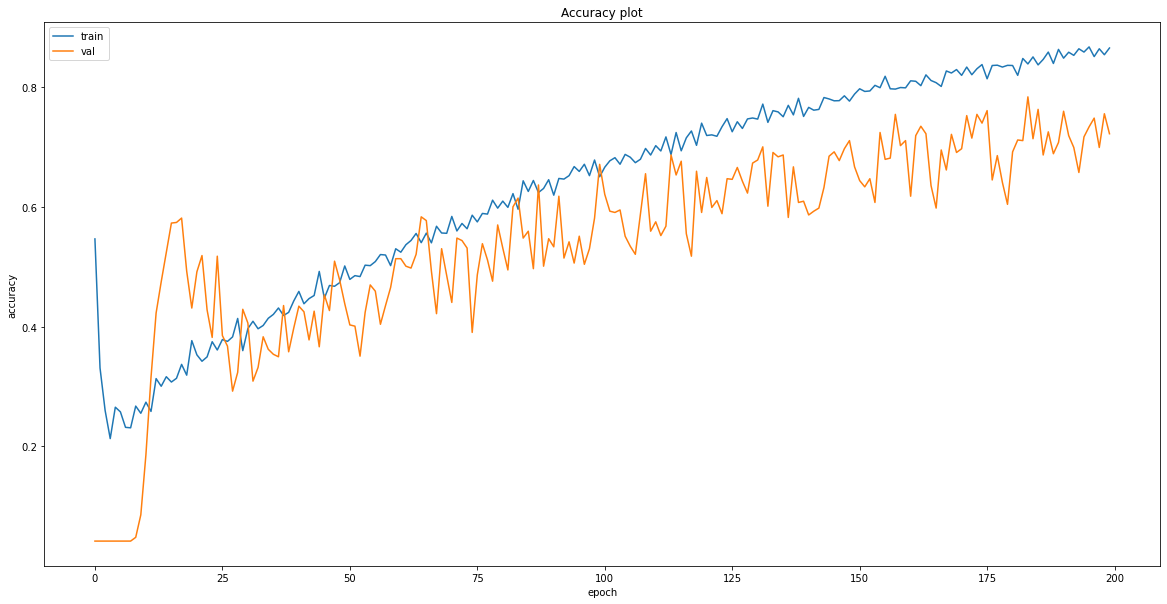

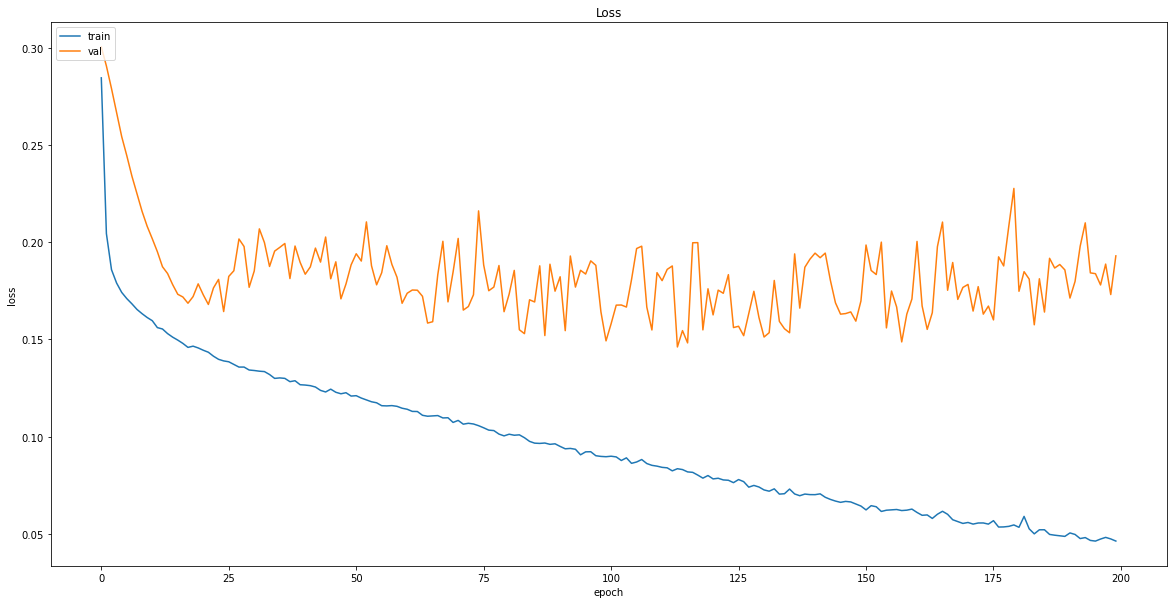

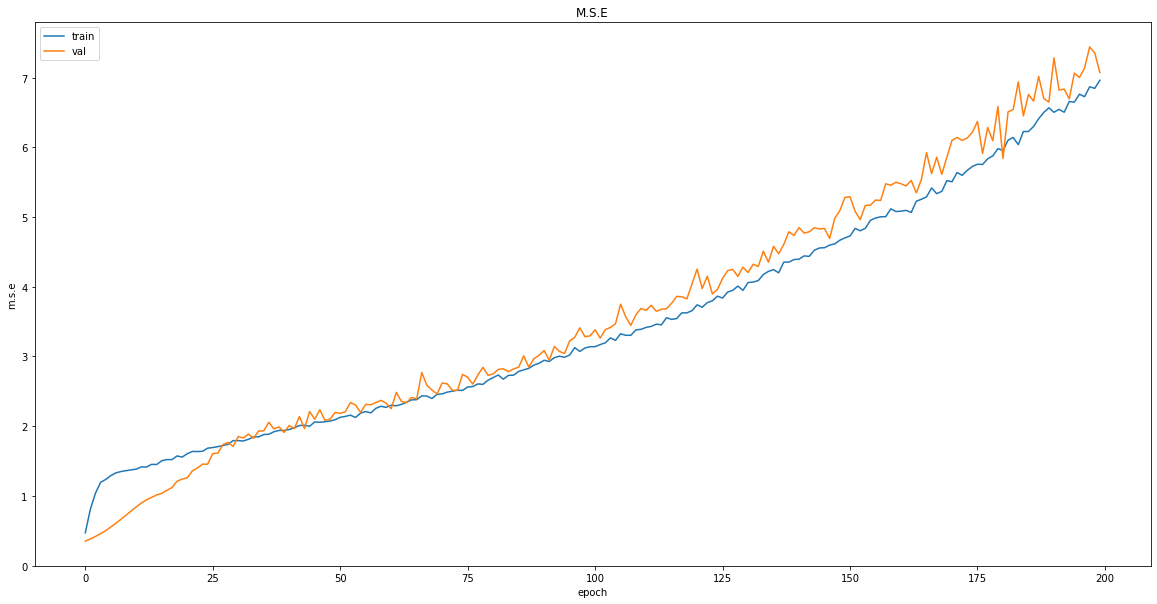

In [73]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('M.S.E')
plt.ylabel('m.s.e')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [74]:
# Save model
model.save("models/{}".format('ocbc_time_series_lstm_buy_hold_sell_no_willr.model'))

INFO:tensorflow:Assets written to: models/ocbc_time_series_lstm_buy_hold_sell_no_willr.model\assets


### Test Performance

### non-recession

In [75]:
logger = []

In [76]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-21        11.75  11.523654 -10.869606  21160951.0     2.0
2019-01-22        11.73  11.555399 -13.978517  18040951.0     2.0
2019-01-23        11.50  11.546876 -38.709667  14286851.0     1.0
2019-01-24        11.38  11.521203 -51.612890   8454651.0     2.0
2019-01-25        11.41  11.504095 -80.357185  12469051.0     2.0


In [77]:
df.drop(['willr_14'], axis='columns', inplace=True)

In [78]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [79]:
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(218, 15, 3)

In [80]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [81]:
model = tf.keras.models.load_model("models/ocbc_time_series_lstm_buy_hold_sell_no_willr.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1719 - accuracy: 0.6972 - mean_squared_error: 6.3304 - weighted_accuracy: 0.6972 - weighted_mean_squared_error: 6.3304
Test loss: 0.17192327976226807
Test accuracy: 0.6972476840019226


In [82]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({0: 29, 2: 165, 1: 24})

In [83]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 201, 0: 9, 1: 8})

In [84]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data_test.csv")
df.set_index('Date', inplace=True)

In [85]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,11.53,11.457507,-67.857228,17615658.0,2.0,0,2
2019-02-12,11.49,11.468659,-43.902530,20832858.0,2.0,0,2
2019-02-13,11.65,11.471942,-42.424356,17325458.0,2.0,2,2
2019-02-14,11.68,11.499336,-10.256417,22091358.0,2.0,0,2
2019-02-15,11.52,11.527130,-5.714153,24228358.0,2.0,0,2


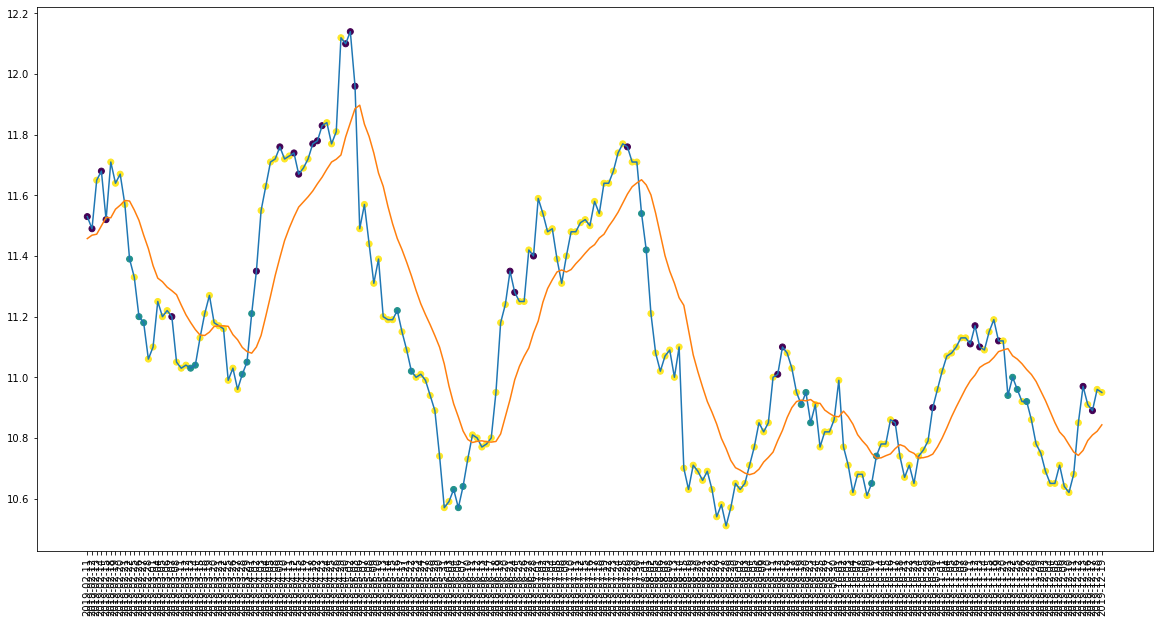

In [86]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

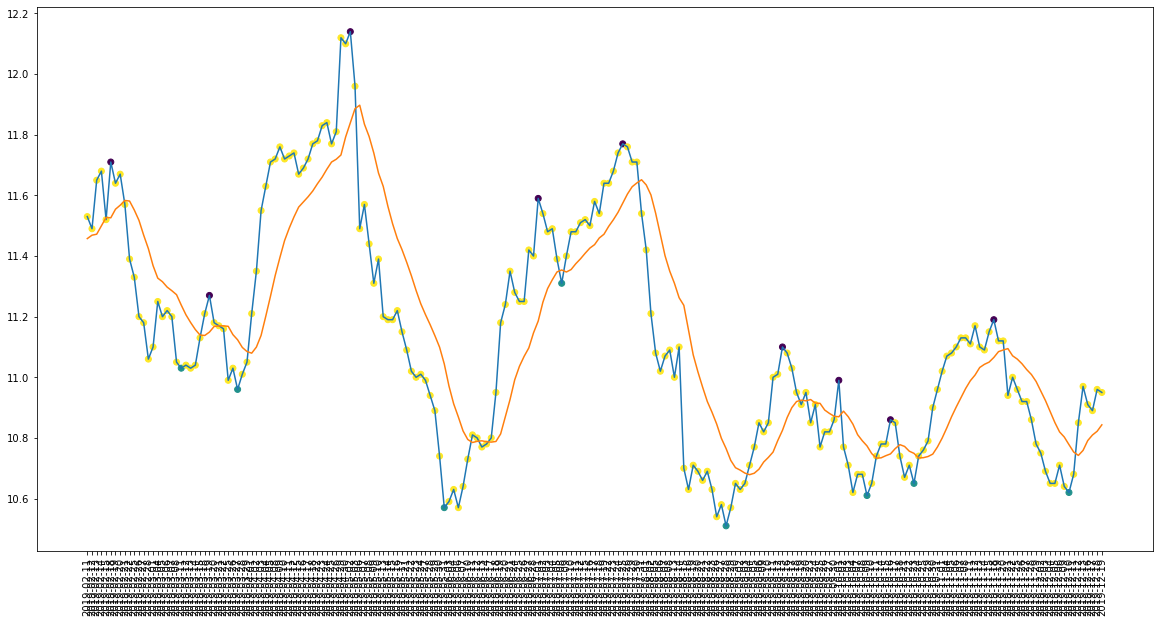

In [87]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [88]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 7
actual holds but predicted buy: 24
actual holds but predicted sell: 27
actual predicted holds: 150
Percentage buys correct: 0.0%
Percentage sells correct: 22.22222222222222%
Percentage holds correct: 74.6268656716418%
actual buys: 8
actual sells: 9
actual holds: 201


In [89]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[11.489999771118164, 11.520000457763672, 11.529999732971193, 11.56999969482422, 11.640000343322756, 11.649999618530273, 11.670000076293945, 11.68000030517578, 11.710000038146973]
[11.0600004196167, 11.100000381469727, 11.18000030517578, 11.199999809265137, 11.329999923706055, 11.390000343322756, 11.56999969482422, 11.640000343322756, 11.670000076293945]
Percentage buys correct: 45.833333333333336%
Percentage sells correct: 65.51724137931035%
Percentage holds correct: 85.97560975609755%


In [90]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $11.390000343322756
Shares owned at the moment: 875
Cash capital at the moment: $6.3425112664681365


Stop Loss Activated!

Share price: $11.0600004196167
Shares owned at the moment: 0
Cash capital at the moment: $9657.229752421377


Share price: $11.029999732971193
Shares owned at the moment: 873
Cash capital at the moment: $1.5597136785945622


Price increase from previously bought: 6.325922060511813%
Share price: $11.760000228881836
Shares owned at the moment: 0
Cash capital at the moment: $10239.807092942949


Share price: $11.220000267028807
Shares owned at the moment: 910
Cash capital at the moment: $1.5287992784942617


Stop Loss Activated!

Share price: $10.890000343322754
Shares owned at the moment: 0
Cash capital at the moment: $9884.176885843035


Share price: $10.630000114440918
Shares owned at the moment: 927
Cash capital at the moment: $3.0682519645652064


Price increase from previously bought: 6.480464323087043%
Share price: $11.350000381469727
Shares owned

In [91]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $9445.467587005614
profit gained: -5.545324129943856%


In [92]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.633027,33.333333333333336%,44.44444444444444%,65.5%,73.6842105263158%,60.526315789473685%,81.69014084507042%,-10.226340083160448%,-7.777238176262399%
1,0.646512,12.5%,11.11111111111111%,69.1919191919192%,40.54054054054054%,55.172413793103445%,85.23489932885906%,-50.75888178490704%,-48.34563047105195%
2,0.697248,0.0%,22.22222222222222%,74.6268656716418%,45.833333333333336%,65.51724137931035%,85.97560975609755%,0.27800619994635783%,-5.545324129943856%


### recession

In [93]:
logger = []

In [94]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22        11.12  11.072811 -24.444379  27489400.0     2.0
2020-01-23        11.19  11.090840  -8.888884  31751200.0     2.0
2020-01-24        11.11  11.093787 -26.666653  27359800.0     2.0
2020-01-28        11.10  11.094743 -28.888715  24699300.0     2.0
2020-01-29        10.90  11.064783 -71.739257  16499235.0     2.0


In [95]:
df.drop(['willr_14'], axis='columns', inplace=True)

In [96]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [97]:
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(215, 15, 3)

In [98]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [99]:
model = tf.keras.models.load_model("models/ocbc_time_series_lstm_buy_hold_sell_no_willr.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 4ms/step - loss: 0.2502 - accuracy: 0.6512 - mean_squared_error: 6.6531 - weighted_accuracy: 0.6512 - weighted_mean_squared_error: 6.6531
Test loss: 0.25022056698799133
Test accuracy: 0.6511628031730652


In [100]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 152, 0: 32, 1: 31})

In [101]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 193, 0: 10, 1: 12})

In [102]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data_test2.csv")
df.set_index('Date', inplace=True)

In [103]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-12,11.02,10.890637,-80.357049,13333200.0,2.0,2,2
2020-02-13,11.05,10.910539,-32.075322,21593100.0,2.0,2,2
2020-02-14,11.06,10.931995,-15.217324,25962500.0,2.0,2,2
2020-02-17,11.01,10.951688,-13.043361,29610200.0,2.0,0,2
2020-02-18,10.97,10.960659,-23.912967,27996300.0,2.0,0,2


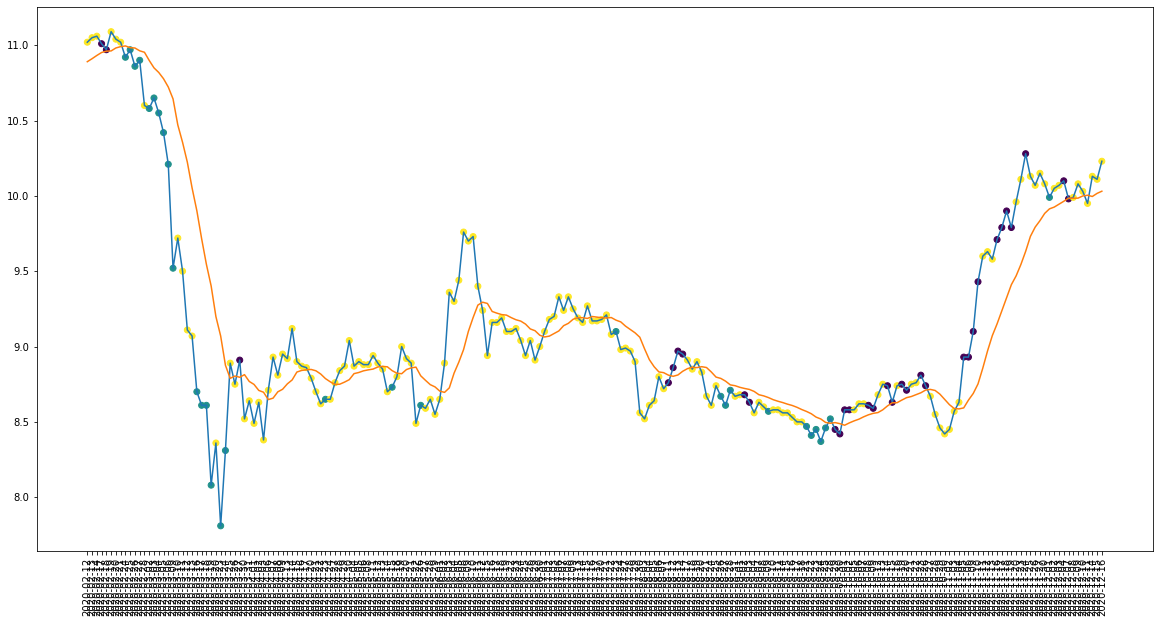

In [104]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

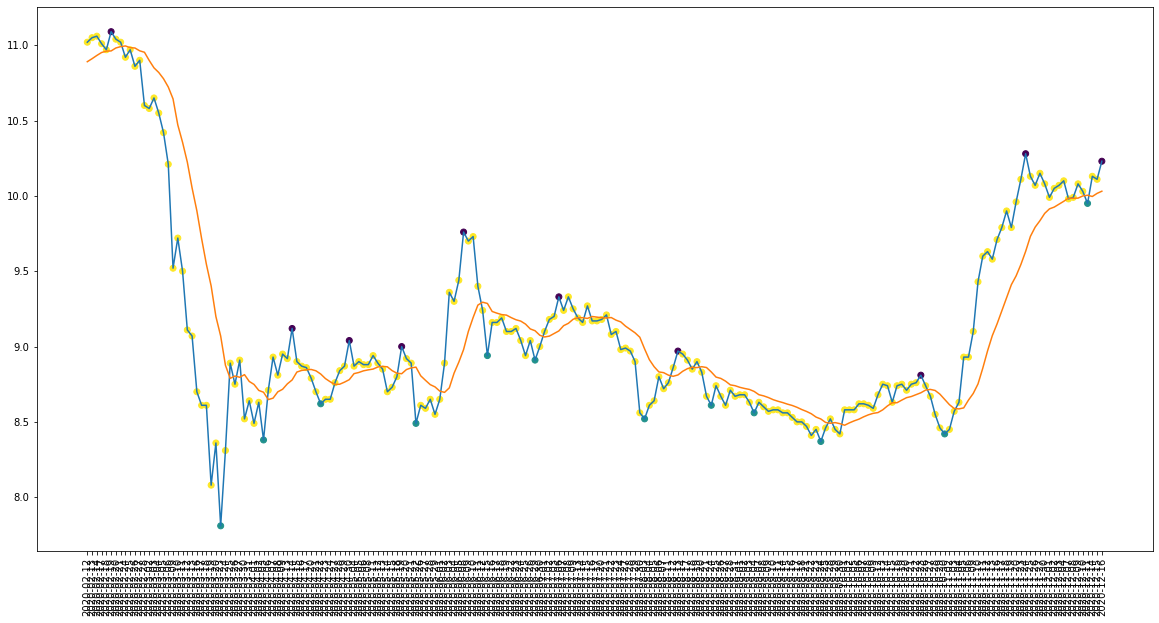

In [105]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [106]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 215
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 10
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 7
actual holds but predicted buy: 29
actual holds but predicted sell: 29
actual predicted holds: 135
Percentage buys correct: 16.666666666666668%
Percentage sells correct: 30.0%
Percentage holds correct: 69.94818652849742%
actual buys: 12
actual sells: 10
actual holds: 193


In [107]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[10.920000076293944, 10.970000267028807, 11.010000228881836, 11.020000457763672, 11.020000457763672, 11.039999961853027, 11.050000190734863, 11.0600004196167, 11.09000015258789]
[10.579999923706056, 10.600000381469727, 10.649999618530273, 10.859999656677246, 10.899999618530273, 10.920000076293944, 10.970000267028807, 11.020000457763672, 11.039999961853027]
Percentage buys correct: 58.064516129032256%
Percentage sells correct: 53.125%
Percentage holds correct: 85.43046357615894%


In [108]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $10.920000076293944
Shares owned at the moment: 913
Cash capital at the moment: $2.6225401520750893


Stop Loss Activated!

Share price: $10.600000381469727
Shares owned at the moment: 0
Cash capital at the moment: $9653.80893747616


Share price: $10.579999923706056
Shares owned at the moment: 909
Cash capital at the moment: $10.14165201807009


Stop Loss Activated!

Share price: $10.210000038146973
Shares owned at the moment: 0
Cash capital at the moment: $9265.50923909831


Share price: $10.210000038146973
Shares owned at the moment: 905
Cash capital at the moment: $0.04906698036029411


Stop Loss Activated!

Share price: $9.520000457763672
Shares owned at the moment: 0
Cash capital at the moment: $8591.956580117223


Share price: $9.520000457763672
Shares owned at the moment: 900
Cash capital at the moment: $0.3941669969535724


Stop Loss Activated!

Share price: $9.109999656677246
Shares owned at the moment: 0
Cash capital at the moment: $8176.846608856199


Share pri

In [109]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $9233.011672363282
profit gained: -7.669883276367181%


In [110]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.633027,33.333333333333336%,44.44444444444444%,65.5%,73.6842105263158%,60.526315789473685%,81.69014084507042%,-10.226340083160448%,-7.777238176262399%
1,0.646512,12.5%,11.11111111111111%,69.1919191919192%,40.54054054054054%,55.172413793103445%,85.23489932885906%,-50.75888178490704%,-48.34563047105195%
2,0.697248,0.0%,22.22222222222222%,74.6268656716418%,45.833333333333336%,65.51724137931035%,85.97560975609755%,0.27800619994635783%,-5.545324129943856%
3,0.651163,16.666666666666668%,30.0%,69.94818652849742%,58.064516129032256%,53.125%,85.43046357615894%,-14.343298580888566%,-7.669883276367181%


## CNOOC Limited

In [111]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14       OBV_7  labels
0  2004-04-07        3.250  3.264699 -57.142857  31539206.0     2.0
1  2004-04-08        3.200  3.254745 -78.947368 -24878594.0     2.0
2  2004-04-13        3.250  3.254015 -52.631579  10937473.0     0.0
3  2004-04-14        3.375  3.272628 -10.416706  98972973.0     2.0
4  2004-04-15        3.275  3.272993 -52.083331  47190715.0     2.0


In [112]:
df.drop(['willr_14'], axis='columns', inplace=True)

In [113]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,OBV_7,labels
Date,,,,
2004-04-07,3.250,3.264699,31539206.0,2.0
2004-04-08,3.200,3.254745,-24878594.0,2.0
2004-04-13,3.250,3.254015,10937473.0,0.0
2004-04-14,3.375,3.272628,98972973.0,2.0
2004-04-15,3.275,3.272993,47190715.0,2.0


In [114]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [115]:
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
X.shape

(3590, 15, 3)

In [116]:
y = labels
y = np.array(y)

In [117]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [118]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [119]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [120]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [121]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
23/23 [==============================] - 1s 46ms/step - loss: 0.2980 - accuracy: 0.5689 - mse: 0.4308 - weighted_accuracy: 0.3348 - weighted_mse: 0.5340 - val_loss: 0.3025 - val_accuracy: 0.0446 - val_mse: 0.3479 - val_weighted_accuracy: 0.0446 - val_weighted_mse: 0.3479
Epoch 2/200
23/23 [==============================] - 0s 10ms/step - loss: 0.2171 - accuracy: 0.4098 - mse: 0.7049 - weighted_accuracy: 0.4284 - weighted_mse: 0.7303 - val_loss: 0.2962 - val_accuracy: 0.0446 - val_mse: 0.3683 - val_weighted_accuracy: 0.0446 - val_weighted_mse: 0.3683
Epoch 3/200
23/23 [==============================] - 0s 10ms/step - loss: 0.1932 - accuracy: 0.2671 - mse: 0.9230 - weighted_accuracy: 0.4801 - weighted_mse: 0.9019 - val_loss: 0.2884 - val_accuracy: 0.0446 - val_mse: 0.3952 - val_weighted_accuracy: 0.0446 - val_weighted_mse: 0.3952
Epoch 4/200
23/23 [==============================] - 0s 10ms/step - loss: 0.1840 - accuracy: 0.2792 - mse: 1.0601 - weighted_accuracy: 0.4992 - weig

Epoch 30/200
23/23 [==============================] - 0s 10ms/step - loss: 0.1401 - accuracy: 0.3423 - mse: 1.6251 - weighted_accuracy: 0.7057 - weighted_mse: 1.5305 - val_loss: 0.1762 - val_accuracy: 0.4248 - val_mse: 1.4427 - val_weighted_accuracy: 0.4248 - val_weighted_mse: 1.4427
Epoch 31/200
23/23 [==============================] - 0s 11ms/step - loss: 0.1402 - accuracy: 0.3799 - mse: 1.6031 - weighted_accuracy: 0.7051 - weighted_mse: 1.5248 - val_loss: 0.1834 - val_accuracy: 0.3774 - val_mse: 1.5171 - val_weighted_accuracy: 0.3774 - val_weighted_mse: 1.5171
Epoch 32/200
23/23 [==============================] - 0s 11ms/step - loss: 0.1389 - accuracy: 0.3562 - mse: 1.6554 - weighted_accuracy: 0.6818 - weighted_mse: 1.5708 - val_loss: 0.1748 - val_accuracy: 0.4443 - val_mse: 1.5408 - val_weighted_accuracy: 0.4443 - val_weighted_mse: 1.5408
Epoch 33/200
23/23 [==============================] - 0s 10ms/step - loss: 0.1386 - accuracy: 0.3294 - mse: 1.6563 - weighted_accuracy: 0.6841 - 

Epoch 59/200
23/23 [==============================] - 0s 11ms/step - loss: 0.1194 - accuracy: 0.4526 - mse: 2.0792 - weighted_accuracy: 0.7680 - weighted_mse: 2.0369 - val_loss: 0.1802 - val_accuracy: 0.4499 - val_mse: 2.0971 - val_weighted_accuracy: 0.4499 - val_weighted_mse: 2.0971
Epoch 60/200
23/23 [==============================] - 0s 11ms/step - loss: 0.1192 - accuracy: 0.4983 - mse: 2.0874 - weighted_accuracy: 0.7726 - weighted_mse: 2.0601 - val_loss: 0.1863 - val_accuracy: 0.4206 - val_mse: 2.1040 - val_weighted_accuracy: 0.4206 - val_weighted_mse: 2.1040
Epoch 61/200
23/23 [==============================] - 0s 11ms/step - loss: 0.1186 - accuracy: 0.4760 - mse: 2.1100 - weighted_accuracy: 0.7670 - weighted_mse: 2.0746 - val_loss: 0.1890 - val_accuracy: 0.4234 - val_mse: 2.1470 - val_weighted_accuracy: 0.4234 - val_weighted_mse: 2.1470
Epoch 62/200
23/23 [==============================] - 0s 10ms/step - loss: 0.1189 - accuracy: 0.4903 - mse: 2.1369 - weighted_accuracy: 0.7601 - 

Epoch 88/200
23/23 [==============================] - 0s 11ms/step - loss: 0.1032 - accuracy: 0.5884 - mse: 2.5772 - weighted_accuracy: 0.8275 - weighted_mse: 2.6137 - val_loss: 0.1729 - val_accuracy: 0.5139 - val_mse: 2.7833 - val_weighted_accuracy: 0.5139 - val_weighted_mse: 2.7833
Epoch 89/200
23/23 [==============================] - 0s 11ms/step - loss: 0.1024 - accuracy: 0.6111 - mse: 2.6229 - weighted_accuracy: 0.8382 - weighted_mse: 2.6655 - val_loss: 0.1749 - val_accuracy: 0.5237 - val_mse: 2.5651 - val_weighted_accuracy: 0.5237 - val_weighted_mse: 2.5651
Epoch 90/200
23/23 [==============================] - 0s 11ms/step - loss: 0.1014 - accuracy: 0.6215 - mse: 2.6186 - weighted_accuracy: 0.8251 - weighted_mse: 2.6788 - val_loss: 0.1793 - val_accuracy: 0.4903 - val_mse: 2.7120 - val_weighted_accuracy: 0.4903 - val_weighted_mse: 2.7120
Epoch 91/200
23/23 [==============================] - 0s 11ms/step - loss: 0.1034 - accuracy: 0.5877 - mse: 2.6208 - weighted_accuracy: 0.8271 - 

23/23 [==============================] - 0s 7ms/step - loss: 0.0873 - accuracy: 0.7065 - mse: 3.2357 - weighted_accuracy: 0.8731 - weighted_mse: 3.2999 - val_loss: 0.1865 - val_accuracy: 0.5599 - val_mse: 3.4788 - val_weighted_accuracy: 0.5599 - val_weighted_mse: 3.4788
Epoch 117/200
23/23 [==============================] - 0s 6ms/step - loss: 0.0849 - accuracy: 0.6776 - mse: 3.2819 - weighted_accuracy: 0.8745 - weighted_mse: 3.3697 - val_loss: 0.1496 - val_accuracy: 0.6630 - val_mse: 3.2724 - val_weighted_accuracy: 0.6630 - val_weighted_mse: 3.2724
Epoch 118/200
23/23 [==============================] - 0s 6ms/step - loss: 0.0839 - accuracy: 0.7114 - mse: 3.2701 - weighted_accuracy: 0.8844 - weighted_mse: 3.3522 - val_loss: 0.1756 - val_accuracy: 0.5989 - val_mse: 3.4194 - val_weighted_accuracy: 0.5989 - val_weighted_mse: 3.4194
Epoch 119/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0844 - accuracy: 0.6939 - mse: 3.2845 - weighted_accuracy: 0.8805 - weighted_mse: 

Epoch 145/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0740 - accuracy: 0.7577 - mse: 4.2145 - weighted_accuracy: 0.8967 - weighted_mse: 4.2991 - val_loss: 0.2246 - val_accuracy: 0.4889 - val_mse: 4.3288 - val_weighted_accuracy: 0.4889 - val_weighted_mse: 4.3288
Epoch 146/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0694 - accuracy: 0.7535 - mse: 4.1972 - weighted_accuracy: 0.9047 - weighted_mse: 4.2831 - val_loss: 0.1581 - val_accuracy: 0.7075 - val_mse: 4.5846 - val_weighted_accuracy: 0.7075 - val_weighted_mse: 4.5846
Epoch 147/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0687 - accuracy: 0.7848 - mse: 4.2605 - weighted_accuracy: 0.9115 - weighted_mse: 4.3330 - val_loss: 0.1798 - val_accuracy: 0.6156 - val_mse: 4.3217 - val_weighted_accuracy: 0.6156 - val_weighted_mse: 4.3217
Epoch 148/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0680 - accuracy: 0.7928 - mse: 4.3331 - weighted_accuracy: 0.9192 - 

Epoch 174/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0583 - accuracy: 0.8322 - mse: 5.4702 - weighted_accuracy: 0.9384 - weighted_mse: 5.4652 - val_loss: 0.1845 - val_accuracy: 0.6685 - val_mse: 5.5152 - val_weighted_accuracy: 0.6685 - val_weighted_mse: 5.5152
Epoch 175/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0600 - accuracy: 0.8043 - mse: 5.4650 - weighted_accuracy: 0.9162 - weighted_mse: 5.4561 - val_loss: 0.1785 - val_accuracy: 0.7201 - val_mse: 5.8229 - val_weighted_accuracy: 0.7201 - val_weighted_mse: 5.8229
Epoch 176/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0545 - accuracy: 0.8301 - mse: 5.4929 - weighted_accuracy: 0.9353 - weighted_mse: 5.4628 - val_loss: 0.1681 - val_accuracy: 0.7465 - val_mse: 5.8060 - val_weighted_accuracy: 0.7465 - val_weighted_mse: 5.8060
Epoch 177/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0567 - accuracy: 0.8329 - mse: 5.5171 - weighted_accuracy: 0.9387 - 

In [122]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

Test loss: 0.186897411942482
Test accuracy: 0.7548746466636658


In [123]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.3686011  -4.3733582   0.68349856]
 [-2.5099247  -1.9437577   0.7038479 ]
 [-5.7320466  -3.1101933   2.265828  ]
 ...
 [-6.0744376  -0.9333964   0.3861151 ]
 [-0.66859895 -2.6809418   0.08045606]
 [-1.7133652  -6.168213    2.2734427 ]]


Counter({2: 592, 0: 74, 1: 52})

In [124]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 653, 0: 33, 1: 32})

In [125]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 718
actual predicted buys: 3
actual buys but predicted sell: 1
actual buys but predicted hold: 28
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 29
actual holds but predicted buy: 49
actual holds but predicted sell: 69
actual predicted holds: 535
Percentage buys correct: 9.375%
Percentage sells correct: 12.121212121212121%
Percentage holds correct: 81.92955589586524%
actual buys: 32
actual sells: 33
actual holds: 653


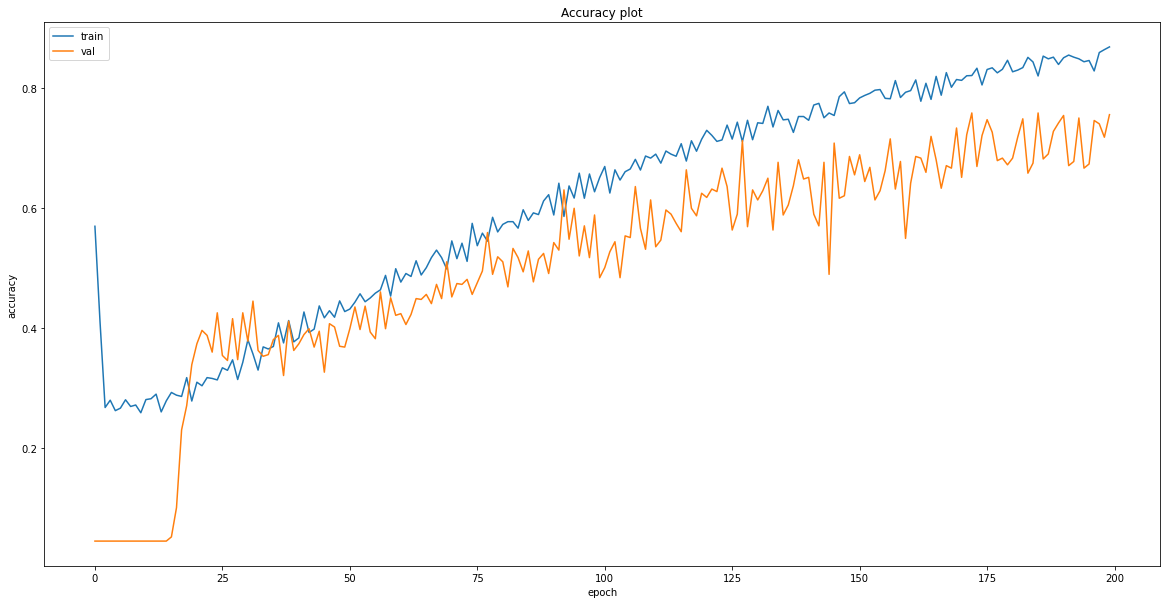

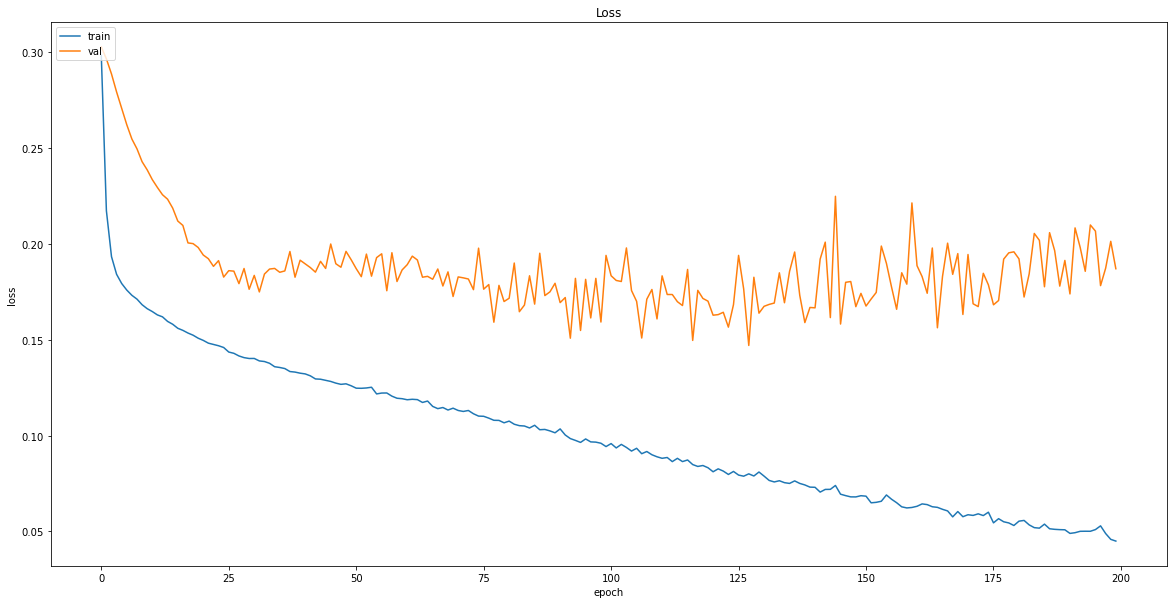

In [126]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [127]:
# Save model
model.save("models/{}".format('cnooc_time_series_lstm_buy_hold_sell_no_willr.model'))

INFO:tensorflow:Assets written to: models/cnooc_time_series_lstm_buy_hold_sell_no_willr.model\assets


### Test Performance

### non-recession

In [128]:
logger = []

In [129]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2019-01-22        13.12  12.552209  -3.030323  489168111.0     2.0
2019-01-23        12.94  12.611869 -13.043517  449876554.0     2.0
2019-01-24        12.62  12.613120 -33.333352  395082483.0     2.0
2019-01-25        12.80  12.641871 -37.254896  441807090.0     2.0
2019-01-28        13.06  12.706198 -11.764689  494043477.0     2.0


In [130]:
df.drop(['willr_14'], axis='columns', inplace=True)

In [131]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(211, 15, 3)

In [132]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [133]:
model = tf.keras.models.load_model("models/cnooc_time_series_lstm_buy_hold_sell_no_willr.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1846 - accuracy: 0.7299 - mean_squared_error: 6.7311 - weighted_accuracy: 0.7299 - weighted_mean_squared_error: 6.7311
Test loss: 0.18463917076587677
Test accuracy: 0.7298578023910522


In [134]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 168, 0: 21, 1: 22})

In [135]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [136]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data_test.csv")
df.set_index('Date', inplace=True)

In [137]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-14,13.46,13.005887,-9.090899,594167146.0,2.0,2,2
2019-02-15,13.28,13.075751,-2.222168,636062191.0,2.0,0,2
2019-02-18,13.68,13.107174,-22.222210,601994876.0,2.0,0,2
2019-02-19,13.76,13.195301,-15.384598,654106730.0,2.0,0,2
2019-02-20,13.92,13.282178,-9.230759,687559434.0,2.0,2,2


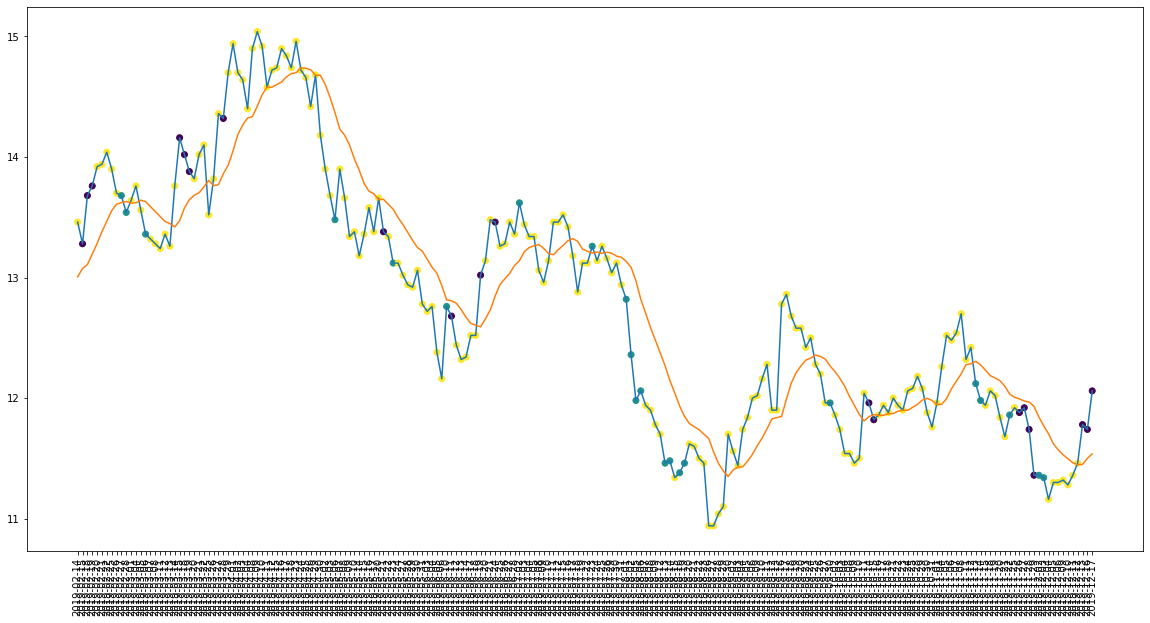

In [138]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

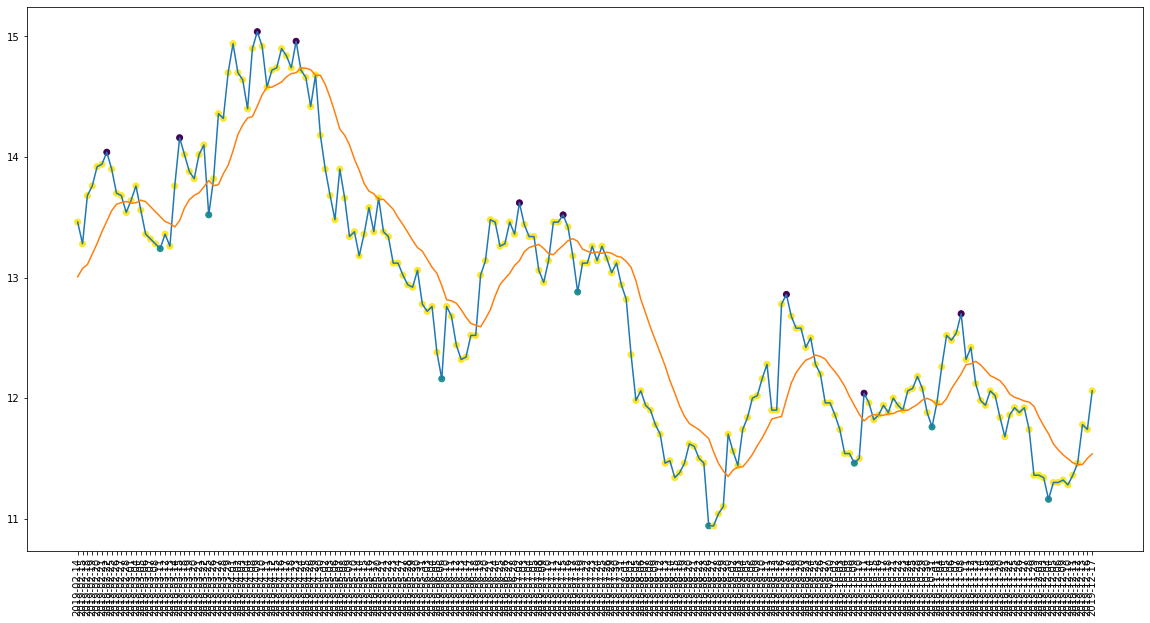

In [139]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [140]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 211
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 7
actual holds but predicted buy: 21
actual holds but predicted sell: 20
actual predicted holds: 153
Percentage buys correct: 0.0%
Percentage sells correct: 11.11111111111111%
Percentage holds correct: 78.8659793814433%
actual buys: 8
actual sells: 9
actual holds: 194


In [141]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[13.279999732971193, 13.460000038146973, 13.68000030517578, 13.699999809265135, 13.760000228881836, 13.899999618530273, 13.920000076293945, 13.9399995803833, 14.039999961853027]
[13.359999656677244, 13.539999961853027, 13.5600004196167, 13.640000343322756, 13.68000030517578, 13.699999809265135, 13.760000228881836, 13.899999618530273, 14.039999961853027]
Percentage buys correct: 50.0%
Percentage sells correct: 55.0%
Percentage holds correct: 82.14285714285714%


In [142]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $13.68000030517578
Shares owned at the moment: 728
Cash capital at the moment: $13.572417221070282


Stop Loss Activated!

Share price: $13.279999732971193
Shares owned at the moment: 0
Cash capital at the moment: $9654.825663358692


Share price: $13.479999542236328
Shares owned at the moment: 714
Cash capital at the moment: $3.6380111007711093


Stop Loss Activated!

Share price: $13.020000457763672
Shares owned at the moment: 0
Cash capital at the moment: $9274.353567045213


Share price: $12.760000228881836
Shares owned at the moment: 724
Cash capital at the moment: $10.708240879059304


Stop Loss Activated!

Share price: $12.31999969482422
Shares owned at the moment: 0
Cash capital at the moment: $8905.8589005394


Share price: $13.619999885559082
Shares owned at the moment: 652
Cash capital at the moment: $1.198315360072229


Stop Loss Activated!

Share price: $13.0600004196167
Shares owned at the moment: 0
Cash capital at the moment: $8492.902008197787


Share price

In [143]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $8912.067081356048
profit gained: -10.879329186439518%


In [144]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.633027,33.333333333333336%,44.44444444444444%,65.5%,73.6842105263158%,60.526315789473685%,81.69014084507042%,-10.226340083160448%,-7.777238176262399%
1,0.646512,12.5%,11.11111111111111%,69.1919191919192%,40.54054054054054%,55.172413793103445%,85.23489932885906%,-50.75888178490704%,-48.34563047105195%
2,0.697248,0.0%,22.22222222222222%,74.6268656716418%,45.833333333333336%,65.51724137931035%,85.97560975609755%,0.27800619994635783%,-5.545324129943856%
3,0.651163,16.666666666666668%,30.0%,69.94818652849742%,58.064516129032256%,53.125%,85.43046357615894%,-14.343298580888566%,-7.669883276367181%
4,0.729858,0.0%,11.11111111111111%,78.8659793814433%,50.0%,55.0%,82.14285714285714%,-36.92919921341418%,-10.879329186439518%


### Recession

In [145]:
logger = []

In [146]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2020-01-22        13.00  13.393678 -83.870980  104646165.0     2.0
2020-01-23        13.34  13.385420 -57.377021  145802714.0     2.0
2020-01-24        13.00  13.326125 -85.245880   96260120.0     2.0
2020-01-29        13.04  13.282106 -80.645176  122828433.0     2.0
2020-01-30        12.46  13.155628 -90.804605   53693706.0     2.0


In [147]:
df.drop(['willr_14'], axis='columns', inplace=True)

In [148]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(213, 15, 3)

In [149]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [150]:
model = tf.keras.models.load_model("models/cnooc_time_series_lstm_buy_hold_sell_no_willr.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1831 - accuracy: 0.7371 - mean_squared_error: 6.8998 - weighted_accuracy: 0.7371 - weighted_mean_squared_error: 6.8998
Test loss: 0.1831388920545578
Test accuracy: 0.737089216709137


In [151]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 167, 1: 24, 0: 22})

In [152]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [153]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data_test2.csv")
df.set_index('Date', inplace=True)

In [154]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-13,12.34,12.385912,-50.526328,113135355.0,2.0,2,2
2020-02-14,12.34,12.378849,-50.588221,60757697.0,2.0,2,2
2020-02-17,12.26,12.372872,-46.153851,60757697.0,2.0,2,2
2020-02-18,12.00,12.355507,-38.709648,5146960.0,2.0,2,2
2020-02-19,12.08,12.300814,-59.677412,-52626865.0,2.0,2,2


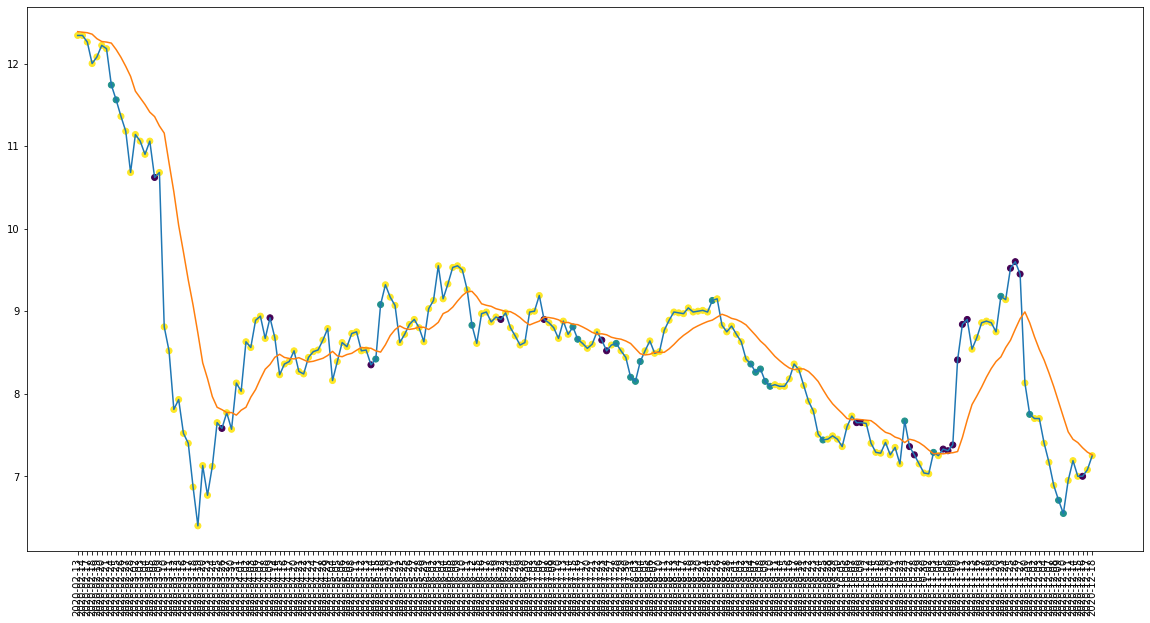

In [155]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

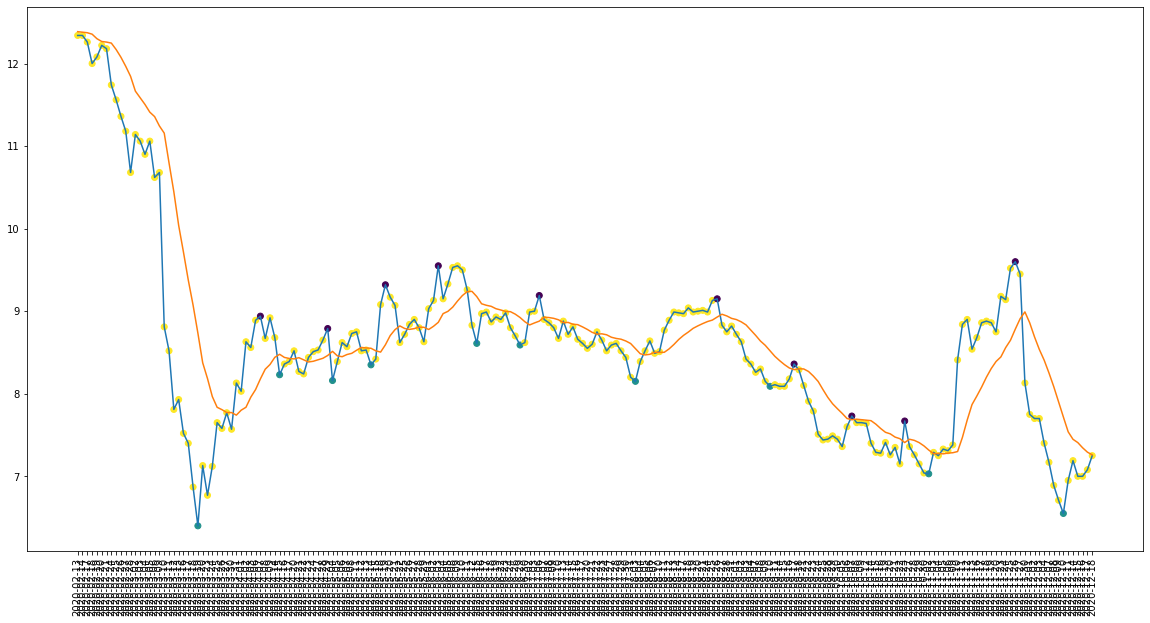

In [156]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [157]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 213
actual predicted buys: 3
actual buys but predicted sell: 1
actual buys but predicted hold: 6
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 8
actual holds but predicted buy: 20
actual holds but predicted sell: 20
actual predicted holds: 153
Percentage buys correct: 30.0%
Percentage sells correct: 10.0%
Percentage holds correct: 79.27461139896373%
actual buys: 10
actual sells: 10
actual holds: 193


In [158]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[11.5600004196167, 11.739999771118164, 12.0, 12.079999923706055, 12.18000030517578, 12.220000267028807, 12.260000228881836, 12.34000015258789, 12.34000015258789]
[10.68000030517578, 10.899999618530273, 11.0600004196167, 11.140000343322754, 11.18000030517578, 11.359999656677244, 11.5600004196167, 11.739999771118164, 12.18000030517578]
Percentage buys correct: 45.833333333333336%
Percentage sells correct: 59.09090909090909%
Percentage holds correct: 81.92771084337349%


In [159]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $11.739999771118164
Shares owned at the moment: 849
Cash capital at the moment: $5.330229855060679


Stop Loss Activated!

Share price: $11.359999656677244
Shares owned at the moment: 0
Cash capital at the moment: $9623.447179175613


Share price: $8.420000076293945
Shares owned at the moment: 1139
Cash capital at the moment: $6.693547037837561


Price increase from previously bought: 5.410827325650591%
Share price: $8.899999618530273
Shares owned at the moment: 0
Cash capital at the moment: $10115.916088738677


Share price: $8.8100004196167
Shares owned at the moment: 1145
Cash capital at the moment: $0.7251194562886667


Stop Loss Activated!

Share price: $8.550000190734862
Shares owned at the moment: 0
Cash capital at the moment: $9763.553524747129


Share price: $8.609999656677246
Shares owned at the moment: 1130
Cash capital at the moment: $7.498338768715257


Stop Loss Activated!

Share price: $8.199999809265138
Shares owned at the moment: 0
Cash capital at the mome

In [160]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $5843.750896369933
profit gained: -41.56249103630067%


In [161]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.633027,33.333333333333336%,44.44444444444444%,65.5%,73.6842105263158%,60.526315789473685%,81.69014084507042%,-10.226340083160448%,-7.777238176262399%
1,0.646512,12.5%,11.11111111111111%,69.1919191919192%,40.54054054054054%,55.172413793103445%,85.23489932885906%,-50.75888178490704%,-48.34563047105195%
2,0.697248,0.0%,22.22222222222222%,74.6268656716418%,45.833333333333336%,65.51724137931035%,85.97560975609755%,0.27800619994635783%,-5.545324129943856%
3,0.651163,16.666666666666668%,30.0%,69.94818652849742%,58.064516129032256%,53.125%,85.43046357615894%,-14.343298580888566%,-7.669883276367181%
4,0.729858,0.0%,11.11111111111111%,78.8659793814433%,50.0%,55.0%,82.14285714285714%,-36.92919921341418%,-10.879329186439518%
5,0.737089,30.0%,10.0%,79.27461139896373%,45.833333333333336%,59.09090909090909%,81.92771084337349%,-16.549326210730143%,-41.56249103630067%


## JP Morgan

In [162]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14       OBV_7  labels
0  2000-01-21    49.375000  48.388499 -42.592593  -2894250.0     2.0
1  2000-01-24    48.625000  48.424884 -39.516144  -8054850.0     2.0
2  2000-01-25    48.666668  48.462081 -38.709668  -1595700.0     2.0
3  2000-01-26    49.750000  48.660222 -17.741956   5984250.0     2.0
4  2000-01-27    52.291668  49.218906  -5.232557  14370900.0     2.0


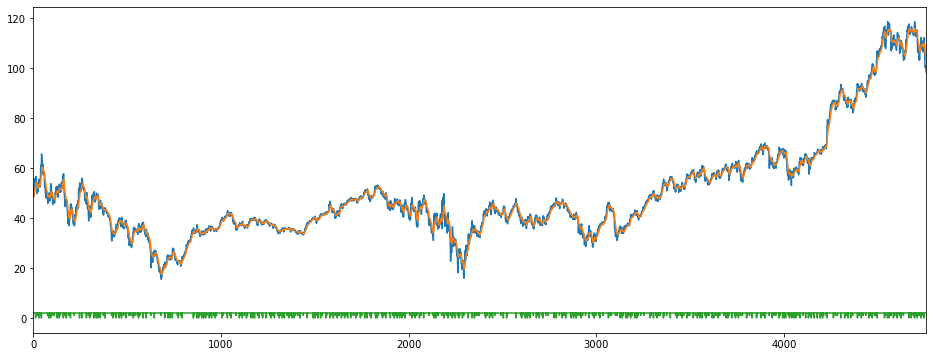

In [163]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [164]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,49.375000,48.388499,-42.592593,-2894250.0,2.0
2000-01-24,48.625000,48.424884,-39.516144,-8054850.0,2.0
2000-01-25,48.666668,48.462081,-38.709668,-1595700.0,2.0
2000-01-26,49.750000,48.660222,-17.741956,5984250.0,2.0
2000-01-27,52.291668,49.218906,-5.232557,14370900.0,2.0


In [165]:
df.drop(['willr_14'], axis='columns', inplace=True)

In [166]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(4745, 15, 3)

In [167]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [168]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [169]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [170]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [171]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 32ms/step - loss: 0.2832 - accuracy: 0.5221 - mse: 0.4828 - weighted_accuracy: 0.3467 - weighted_mse: 0.5544 - val_loss: 0.3005 - val_accuracy: 0.0453 - val_mse: 0.3515 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.3515
Epoch 2/200
30/30 [==============================] - 0s 7ms/step - loss: 0.2045 - accuracy: 0.3180 - mse: 0.8226 - weighted_accuracy: 0.4522 - weighted_mse: 0.8020 - val_loss: 0.2904 - val_accuracy: 0.0453 - val_mse: 0.3802 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.3802
Epoch 3/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1870 - accuracy: 0.2766 - mse: 1.0566 - weighted_accuracy: 0.4812 - weighted_mse: 1.0247 - val_loss: 0.2790 - val_accuracy: 0.0453 - val_mse: 0.4155 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.4155
Epoch 4/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1808 - accuracy: 0.2587 - mse: 1.1880 - weighted_accuracy: 0.5066 - weighte

Epoch 30/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1400 - accuracy: 0.3783 - mse: 1.7020 - weighted_accuracy: 0.7001 - weighted_mse: 1.6135 - val_loss: 0.1909 - val_accuracy: 0.3109 - val_mse: 1.6559 - val_weighted_accuracy: 0.3109 - val_weighted_mse: 1.6559
Epoch 31/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1392 - accuracy: 0.3625 - mse: 1.7413 - weighted_accuracy: 0.6928 - weighted_mse: 1.6437 - val_loss: 0.1973 - val_accuracy: 0.2940 - val_mse: 1.6616 - val_weighted_accuracy: 0.2940 - val_weighted_mse: 1.6616
Epoch 32/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1383 - accuracy: 0.3691 - mse: 1.7688 - weighted_accuracy: 0.7007 - weighted_mse: 1.6831 - val_loss: 0.2010 - val_accuracy: 0.2761 - val_mse: 1.7030 - val_weighted_accuracy: 0.2761 - val_weighted_mse: 1.7030
Epoch 33/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1365 - accuracy: 0.3736 - mse: 1.7599 - weighted_accuracy: 0.7140 - weig

Epoch 59/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1193 - accuracy: 0.5148 - mse: 2.2840 - weighted_accuracy: 0.7771 - weighted_mse: 2.2534 - val_loss: 0.2009 - val_accuracy: 0.3762 - val_mse: 2.2959 - val_weighted_accuracy: 0.3762 - val_weighted_mse: 2.2959
Epoch 60/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1183 - accuracy: 0.5287 - mse: 2.2467 - weighted_accuracy: 0.7780 - weighted_mse: 2.2131 - val_loss: 0.1926 - val_accuracy: 0.3941 - val_mse: 2.2732 - val_weighted_accuracy: 0.3941 - val_weighted_mse: 2.2732
Epoch 61/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1183 - accuracy: 0.5232 - mse: 2.2538 - weighted_accuracy: 0.7741 - weighted_mse: 2.2061 - val_loss: 0.1929 - val_accuracy: 0.4004 - val_mse: 2.3173 - val_weighted_accuracy: 0.4004 - val_weighted_mse: 2.3173
Epoch 62/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1180 - accuracy: 0.5103 - mse: 2.3014 - weighted_accuracy: 0.7715 - weig

Epoch 88/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1014 - accuracy: 0.6267 - mse: 2.8295 - weighted_accuracy: 0.8292 - weighted_mse: 2.8559 - val_loss: 0.1709 - val_accuracy: 0.5364 - val_mse: 2.8976 - val_weighted_accuracy: 0.5364 - val_weighted_mse: 2.8976
Epoch 89/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0987 - accuracy: 0.6409 - mse: 2.8210 - weighted_accuracy: 0.8306 - weighted_mse: 2.8696 - val_loss: 0.1644 - val_accuracy: 0.5764 - val_mse: 2.9357 - val_weighted_accuracy: 0.5764 - val_weighted_mse: 2.9357
Epoch 90/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0994 - accuracy: 0.6341 - mse: 2.9330 - weighted_accuracy: 0.8241 - weighted_mse: 2.9813 - val_loss: 0.1673 - val_accuracy: 0.5564 - val_mse: 3.0997 - val_weighted_accuracy: 0.5564 - val_weighted_mse: 3.0997
Epoch 91/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0988 - accuracy: 0.6367 - mse: 2.8912 - weighted_accuracy: 0.8386 - weig

Epoch 117/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0828 - accuracy: 0.7208 - mse: 3.6268 - weighted_accuracy: 0.8772 - weighted_mse: 3.6859 - val_loss: 0.1693 - val_accuracy: 0.5996 - val_mse: 3.7266 - val_weighted_accuracy: 0.5996 - val_weighted_mse: 3.7266
Epoch 118/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0818 - accuracy: 0.7163 - mse: 3.6586 - weighted_accuracy: 0.8829 - weighted_mse: 3.7092 - val_loss: 0.1778 - val_accuracy: 0.5817 - val_mse: 3.7486 - val_weighted_accuracy: 0.5817 - val_weighted_mse: 3.7486
Epoch 119/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0819 - accuracy: 0.7308 - mse: 3.7043 - weighted_accuracy: 0.8749 - weighted_mse: 3.7726 - val_loss: 0.1734 - val_accuracy: 0.5954 - val_mse: 3.8872 - val_weighted_accuracy: 0.5954 - val_weighted_mse: 3.8872
Epoch 120/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0800 - accuracy: 0.7310 - mse: 3.7218 - weighted_accuracy: 0.8847 - 

Epoch 146/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0673 - accuracy: 0.7956 - mse: 4.6959 - weighted_accuracy: 0.9120 - weighted_mse: 4.7823 - val_loss: 0.1605 - val_accuracy: 0.7039 - val_mse: 4.7967 - val_weighted_accuracy: 0.7039 - val_weighted_mse: 4.7967
Epoch 147/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0684 - accuracy: 0.7890 - mse: 4.6898 - weighted_accuracy: 0.9114 - weighted_mse: 4.7752 - val_loss: 0.1645 - val_accuracy: 0.6660 - val_mse: 5.0821 - val_weighted_accuracy: 0.6660 - val_weighted_mse: 5.0821
Epoch 148/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0668 - accuracy: 0.7845 - mse: 4.7882 - weighted_accuracy: 0.9098 - weighted_mse: 4.8535 - val_loss: 0.1701 - val_accuracy: 0.6786 - val_mse: 4.9606 - val_weighted_accuracy: 0.6786 - val_weighted_mse: 4.9606
Epoch 149/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0665 - accuracy: 0.8006 - mse: 4.7761 - weighted_accuracy: 0.9138 - 

Epoch 175/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0542 - accuracy: 0.8406 - mse: 5.8463 - weighted_accuracy: 0.9379 - weighted_mse: 5.8538 - val_loss: 0.1682 - val_accuracy: 0.7197 - val_mse: 6.0314 - val_weighted_accuracy: 0.7197 - val_weighted_mse: 6.0314
Epoch 176/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0544 - accuracy: 0.8435 - mse: 5.9631 - weighted_accuracy: 0.9428 - weighted_mse: 5.9524 - val_loss: 0.1574 - val_accuracy: 0.7777 - val_mse: 6.2023 - val_weighted_accuracy: 0.7777 - val_weighted_mse: 6.2023
Epoch 177/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0546 - accuracy: 0.8446 - mse: 5.9317 - weighted_accuracy: 0.9261 - weighted_mse: 5.9490 - val_loss: 0.1814 - val_accuracy: 0.6934 - val_mse: 6.2978 - val_weighted_accuracy: 0.6934 - val_weighted_mse: 6.2978
Epoch 178/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0516 - accuracy: 0.8583 - mse: 6.0448 - weighted_accuracy: 0.9386 - 

In [172]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

Test loss: 0.1912064552307129
Test accuracy: 0.7123287916183472


In [173]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-0.33506134 -4.912737   -0.2944933 ]
 [-2.8660421  -3.8471606   2.8709562 ]
 [-1.337005   -6.906161    1.2169265 ]
 ...
 [-0.35443497 -3.572105   -0.23703344]
 [-1.0634944  -3.8537679   0.53002274]
 [-2.040202   -3.108141    1.2832301 ]]


Counter({2: 741, 0: 92, 1: 116})

In [174]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 865, 0: 41, 1: 43})

In [175]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 949
actual predicted buys: 6
actual buys but predicted sell: 2
actual buys but predicted hold: 35
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 38
actual holds but predicted buy: 109
actual holds but predicted sell: 88
actual predicted holds: 668
Percentage buys correct: 13.953488372093023%
Percentage sells correct: 4.878048780487805%
Percentage holds correct: 77.22543352601156%
actual buys: 43
actual sells: 41
actual holds: 865


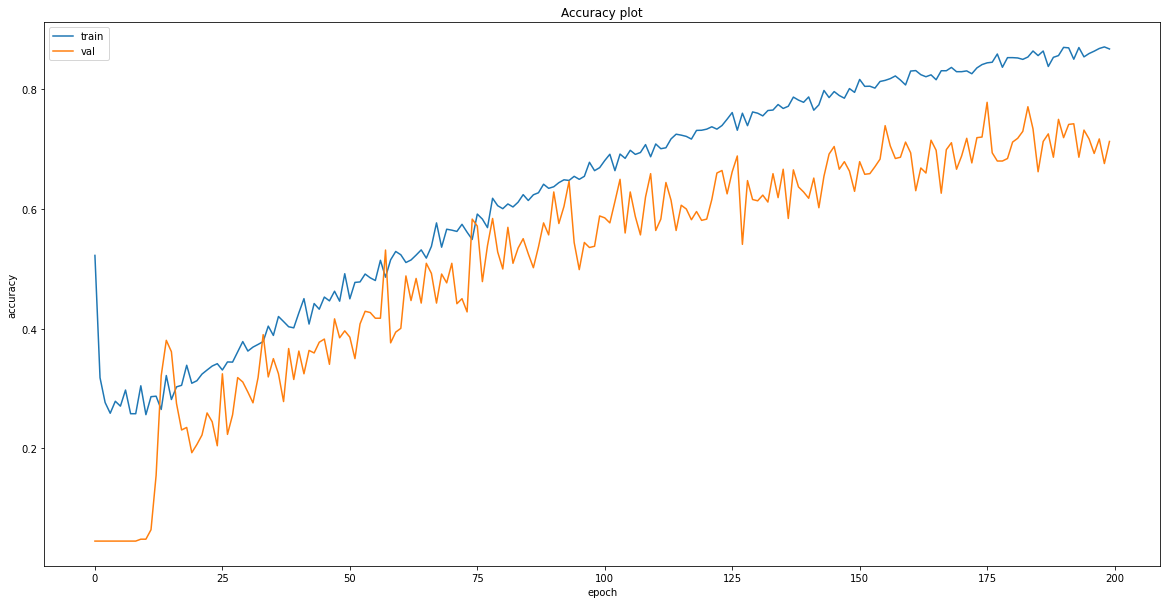

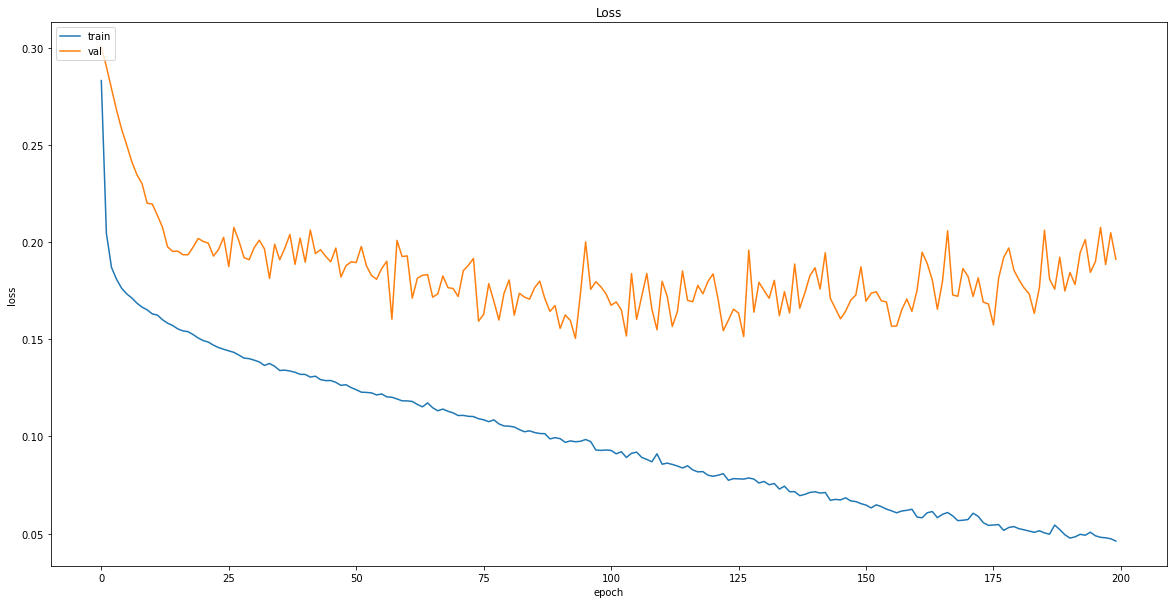

In [176]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [177]:
# Save model
model.save("models/{}".format('jpm_time_series_lstm_buy_hold_sell_no_willr.model'))

INFO:tensorflow:Assets written to: models/jpm_time_series_lstm_buy_hold_sell_no_willr.model\assets


### Test Performance

### non-recession

In [178]:
logger = []

In [179]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2019-01-22   104.589996  101.198442  -3.459880  84335200.0     2.0
2019-01-23   102.940002  101.466374 -21.874992  67251500.0     2.0
2019-01-24   102.680000  101.653086 -27.040213  55104800.0     2.0
2019-01-25   102.739998  101.820303 -32.628441  66401600.0     2.0
2019-01-28   103.389999  102.061795 -23.968276  80771000.0     2.0


In [180]:
df.drop(['willr_14'], axis='columns', inplace=True)

In [181]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(218, 15, 3)

In [182]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [183]:
model = tf.keras.models.load_model("models/jpm_time_series_lstm_buy_hold_sell_no_willr.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 4ms/step - loss: 0.1874 - accuracy: 0.7248 - mean_squared_error: 7.0420 - weighted_accuracy: 0.7248 - weighted_mean_squared_error: 7.0420
Test loss: 0.18744149804115295
Test accuracy: 0.7247706651687622


In [184]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({1: 20, 2: 164, 0: 34})

In [185]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [186]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data_test.csv")
df.set_index('Date', inplace=True)

In [187]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,100.879997,102.975915,-74.903417,73097300.0,1.0,1,1
2019-02-12,102.599998,102.653466,-84.169891,62118800.0,2.0,1,2
2019-02-13,103.089996,102.645240,-50.965236,74971100.0,2.0,2,2
2019-02-14,102.419998,102.713664,-41.505819,85725200.0,2.0,2,2
2019-02-15,105.550003,102.668485,-54.440145,74206700.0,2.0,2,2


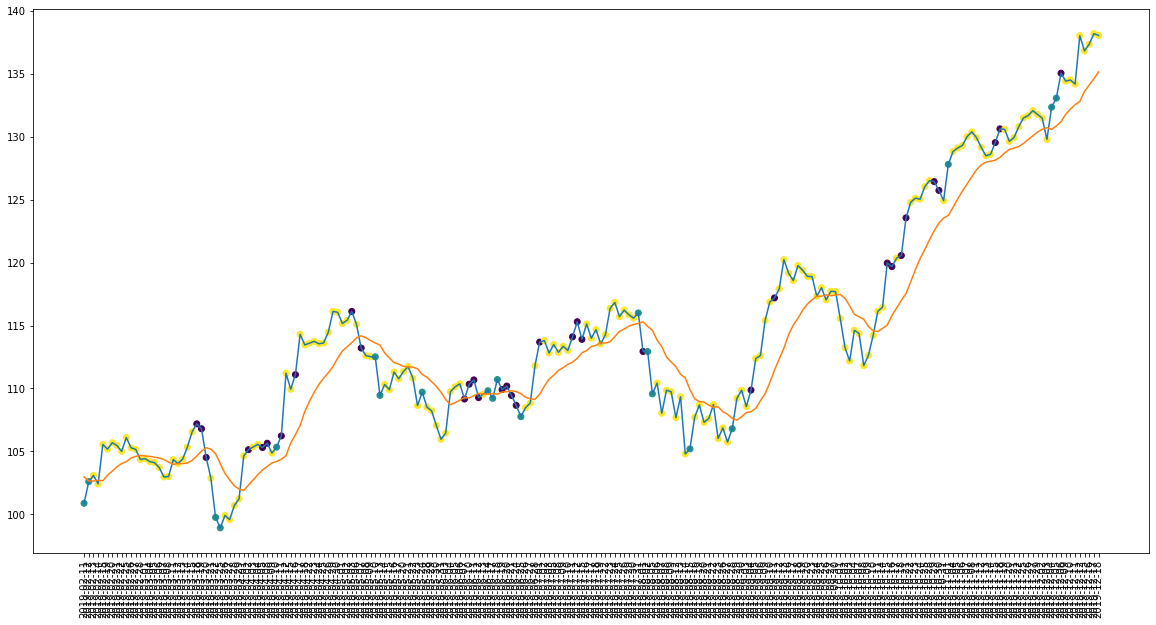

In [188]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

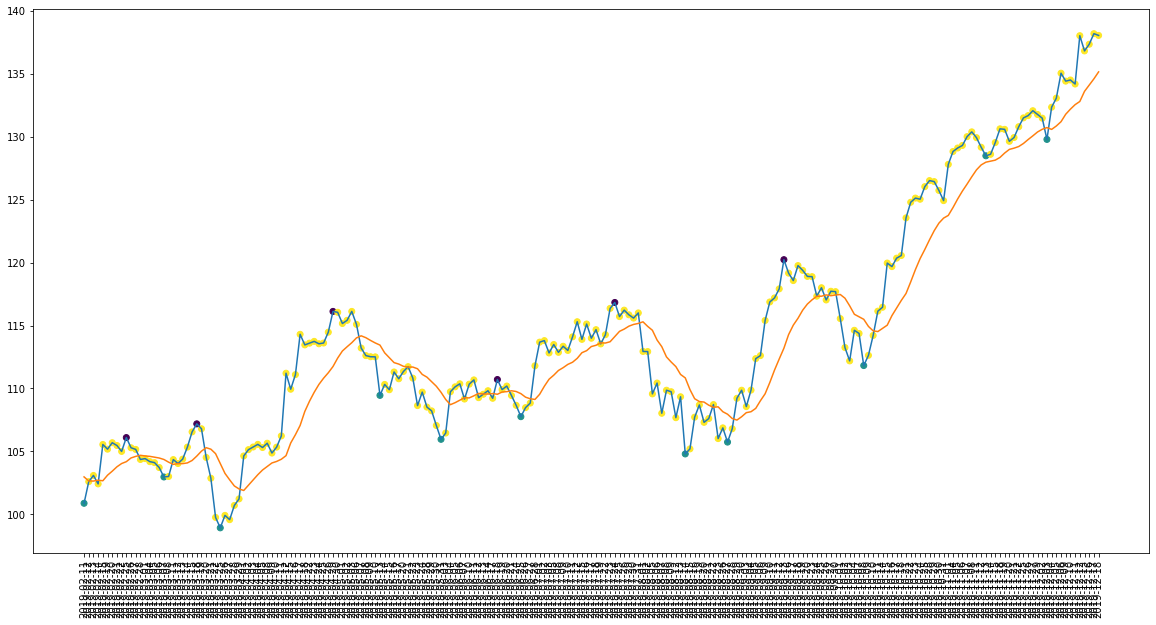

In [189]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [190]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 4
actual holds but predicted buy: 15
actual holds but predicted sell: 33
actual predicted holds: 153
Percentage buys correct: 36.36363636363637%
Percentage sells correct: 16.666666666666668%
Percentage holds correct: 76.11940298507463%
actual buys: 11
actual sells: 6
actual holds: 201


In [191]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[100.87999725341795, 102.41999816894531, 102.5999984741211, 103.08999633789062, 105.0, 105.18000030517578, 105.47000122070312, 105.5500030517578, 105.69000244140624]
[104.19000244140624, 104.36000061035156, 104.43000030517578, 105.0, 105.16000366210938, 105.29000091552734, 105.47000122070312, 105.69000244140624, 106.0999984741211]
Percentage buys correct: 60.0%
Percentage sells correct: 47.05882352941177%
Percentage holds correct: 87.11656441717791%


In [192]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $100.87999725341795
Shares owned at the moment: 98
Cash capital at the moment: $86.57310990524456


Price increase from previously bought: 5.963561901624148%
Share price: $107.19000244140624
Shares owned at the moment: 0
Cash capital at the moment: $10562.305643505097


Share price: $99.76000213623048
Shares owned at the moment: 105
Cash capital at the moment: $58.699718584059156


Price increase from previously bought: 5.1039044574216375%
Share price: $105.13999938964844
Shares owned at the moment: 0
Cash capital at the moment: $11068.040479673384


Share price: $105.33999633789062
Shares owned at the moment: 104
Cash capital at the moment: $82.55362158012213


Price increase from previously bought: 5.178768957301161%
Share price: $111.0999984741211
Shares owned at the moment: 0
Cash capital at the moment: $11605.178863325116


Share price: $112.51000213623048
Shares owned at the moment: 102
Cash capital at the moment: $97.5995898303936


Stop Loss Activated!

Share price

In [193]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $13577.290673755644
profit gained: 35.77290673755644%


In [194]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.633027,33.333333333333336%,44.44444444444444%,65.5%,73.6842105263158%,60.526315789473685%,81.69014084507042%,-10.226340083160448%,-7.777238176262399%
1,0.646512,12.5%,11.11111111111111%,69.1919191919192%,40.54054054054054%,55.172413793103445%,85.23489932885906%,-50.75888178490704%,-48.34563047105195%
2,0.697248,0.0%,22.22222222222222%,74.6268656716418%,45.833333333333336%,65.51724137931035%,85.97560975609755%,0.27800619994635783%,-5.545324129943856%
3,0.651163,16.666666666666668%,30.0%,69.94818652849742%,58.064516129032256%,53.125%,85.43046357615894%,-14.343298580888566%,-7.669883276367181%
4,0.729858,0.0%,11.11111111111111%,78.8659793814433%,50.0%,55.0%,82.14285714285714%,-36.92919921341418%,-10.879329186439518%
5,0.737089,30.0%,10.0%,79.27461139896373%,45.833333333333336%,59.09090909090909%,81.92771084337349%,-16.549326210730143%,-41.56249103630067%
6,0.724771,36.36363636363637%,16.666666666666668%,76.11940298507463%,60.0%,47.05882352941177%,87.11656441717791%,18.24888354415882%,35.77290673755644%


### recession

In [195]:
logger = []

In [196]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2020-01-22   136.839996  137.690058 -77.454723  33776700.0     2.0
2020-01-23   136.679993  137.534664 -80.363881  26227600.0     2.0
2020-01-24   136.539993  137.381637 -69.867648  16881900.0     2.0
2020-01-27   133.149994  136.730615 -90.166021   1715500.0     1.0
2020-01-28   132.029999  136.007444 -79.004573 -11145000.0     2.0


In [197]:
df.drop(['willr_14'], axis='columns', inplace=True)

In [198]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(219, 15, 3)

In [199]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [200]:
model = tf.keras.models.load_model("models/jpm_time_series_lstm_buy_hold_sell_no_willr.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.2420 - accuracy: 0.6941 - mean_squared_error: 7.9558 - weighted_accuracy: 0.6941 - weighted_mean_squared_error: 7.9558
Test loss: 0.24199189245700836
Test accuracy: 0.6940639019012451


In [201]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 171, 0: 16, 1: 32})

In [202]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [203]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data_test2.csv")
df.set_index('Date', inplace=True)

In [204]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,138.000000,136.179383,-6.410124,26757600.0,0.0,2,0
2020-02-12,138.000000,136.459478,-9.001177,33336200.0,2.0,2,2
2020-02-13,137.880005,136.696481,-13.465502,33336200.0,2.0,2,2
2020-02-14,137.460007,136.878562,-14.718062,25888700.0,2.0,0,2
2020-02-18,135.639999,136.968015,-23.401387,19261100.0,2.0,2,2


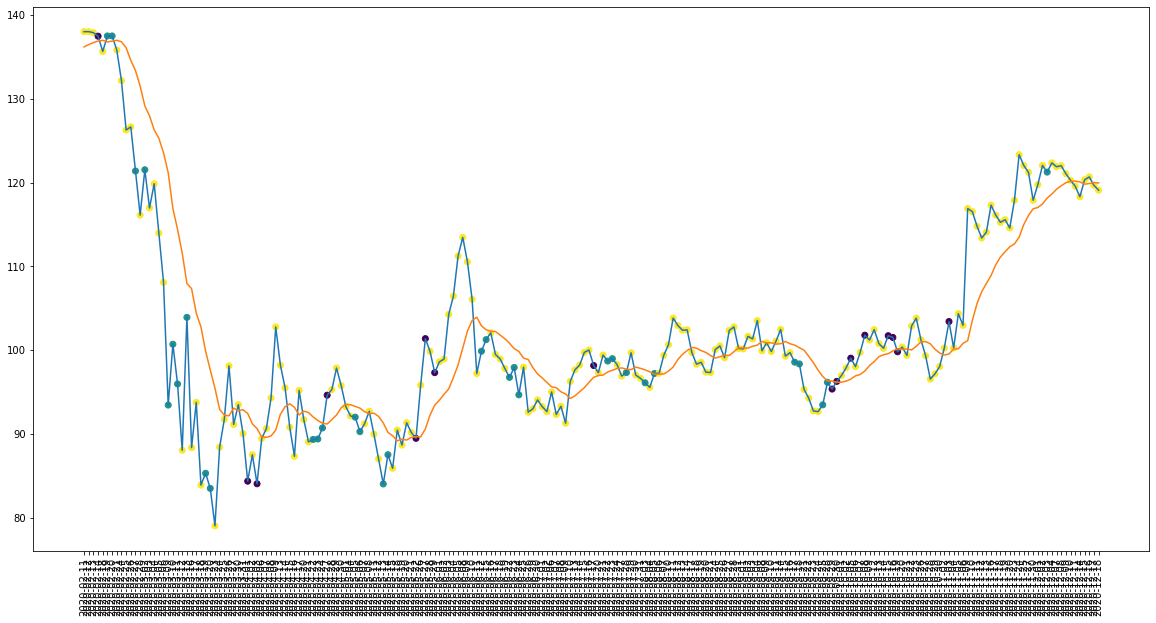

In [205]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

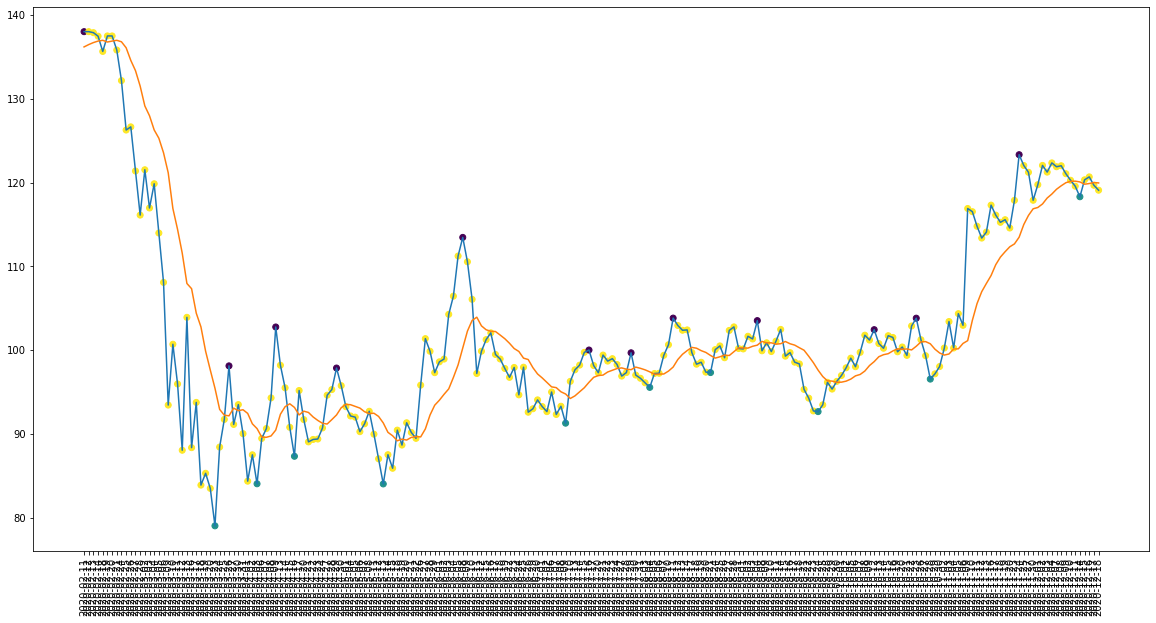

In [206]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [207]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 1
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 12
actual holds but predicted buy: 31
actual holds but predicted sell: 15
actual predicted holds: 151
Percentage buys correct: 10.0%
Percentage sells correct: 0.0%
Percentage holds correct: 76.6497461928934%
actual buys: 10
actual sells: 12
actual holds: 197


In [208]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[132.16000366210938, 135.63999938964844, 135.80999755859378, 137.46000671386722, 137.49000549316406, 137.49000549316406, 137.8800048828125, 138.0, 138.0]
[116.11000061035156, 116.95999908447266, 121.37000274658205, 121.5199966430664, 126.26000213623048, 126.63999938964844, 132.16000366210938, 135.80999755859378, 137.49000549316406]
Percentage buys correct: 50.0%
Percentage sells correct: 50.0%
Percentage holds correct: 80.0%


In [209]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $137.49000549316406
Shares owned at the moment: 72
Cash capital at the moment: $73.49658340454152


Stop Loss Activated!

Share price: $132.16000366210938
Shares owned at the moment: 0
Cash capital at the moment: $9562.849166351318


Share price: $121.37000274658205
Shares owned at the moment: 78
Cash capital at the moment: $69.9550865287747


Stop Loss Activated!

Share price: $116.11000061035156
Shares owned at the moment: 0
Cash capital at the moment: $9101.629539005276


Share price: $121.5199966430664
Shares owned at the moment: 74
Cash capital at the moment: $84.42046810149805


Stop Loss Activated!

Share price: $116.95999908447266
Shares owned at the moment: 0
Cash capital at the moment: $8715.659040538783


Share price: $93.44000244140624
Shares owned at the moment: 93
Cash capital at the moment: $1.8415328636147024


Stop Loss Activated!

Share price: $88.05000305175781
Shares owned at the moment: 0
Cash capital at the moment: $8167.973028396604


Share price: $1

In [210]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $8586.858291473387
profit gained: -14.13141708526613%


In [211]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.633027,33.333333333333336%,44.44444444444444%,65.5%,73.6842105263158%,60.526315789473685%,81.69014084507042%,-10.226340083160448%,-7.777238176262399%
1,0.646512,12.5%,11.11111111111111%,69.1919191919192%,40.54054054054054%,55.172413793103445%,85.23489932885906%,-50.75888178490704%,-48.34563047105195%
2,0.697248,0.0%,22.22222222222222%,74.6268656716418%,45.833333333333336%,65.51724137931035%,85.97560975609755%,0.27800619994635783%,-5.545324129943856%
3,0.651163,16.666666666666668%,30.0%,69.94818652849742%,58.064516129032256%,53.125%,85.43046357615894%,-14.343298580888566%,-7.669883276367181%
4,0.729858,0.0%,11.11111111111111%,78.8659793814433%,50.0%,55.0%,82.14285714285714%,-36.92919921341418%,-10.879329186439518%
5,0.737089,30.0%,10.0%,79.27461139896373%,45.833333333333336%,59.09090909090909%,81.92771084337349%,-16.549326210730143%,-41.56249103630067%
6,0.724771,36.36363636363637%,16.666666666666668%,76.11940298507463%,60.0%,47.05882352941177%,87.11656441717791%,18.24888354415882%,35.77290673755644%
7,0.694064,10.0%,0.0%,76.6497461928934%,50.0%,50.0%,80.0%,-41.281435080108686%,-14.13141708526613%


## American Axle & Manufacturing Holdings, Inc

In [212]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14     OBV_7  labels
0  2000-01-21      16.0625  14.895987 -18.478261  298700.0     2.0
1  2000-01-24      15.8750  15.046605 -22.222222  293100.0     2.0
2  2000-01-25      15.7500  15.154819 -26.190476  286300.0     2.0
3  2000-01-26      15.7500  15.246386 -29.729730  286300.0     2.0
4  2000-01-27      16.0000  15.362326 -25.000000  311700.0     0.0


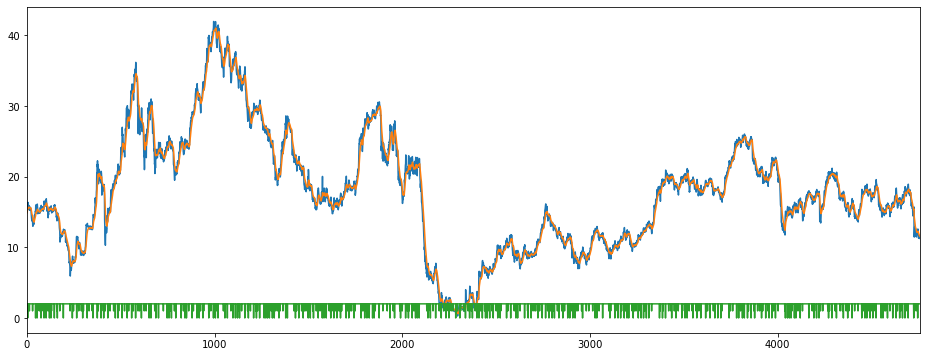

In [213]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [214]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,16.0625,14.895987,-18.478261,298700.0,2.0
2000-01-24,15.8750,15.046605,-22.222222,293100.0,2.0
2000-01-25,15.7500,15.154819,-26.190476,286300.0,2.0
2000-01-26,15.7500,15.246386,-29.729730,286300.0,2.0
2000-01-27,16.0000,15.362326,-25.000000,311700.0,0.0


In [215]:
df.drop(['willr_14'], axis='columns', inplace=True)

In [216]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(4745, 15, 3)

In [217]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [218]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [219]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [220]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [221]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 31ms/step - loss: 0.2872 - accuracy: 0.5464 - mse: 0.4714 - weighted_accuracy: 0.3374 - weighted_mse: 0.5568 - val_loss: 0.3008 - val_accuracy: 0.0464 - val_mse: 0.3519 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 0.3519
Epoch 2/200
30/30 [==============================] - 0s 8ms/step - loss: 0.2070 - accuracy: 0.2827 - mse: 0.8331 - weighted_accuracy: 0.4304 - weighted_mse: 0.8232 - val_loss: 0.2910 - val_accuracy: 0.0464 - val_mse: 0.3826 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 0.3826
Epoch 3/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1885 - accuracy: 0.2360 - mse: 1.0536 - weighted_accuracy: 0.4735 - weighted_mse: 1.0226 - val_loss: 0.2779 - val_accuracy: 0.0464 - val_mse: 0.4169 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 0.4169
Epoch 4/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1819 - accuracy: 0.2466 - mse: 1.1722 - weighted_accuracy: 0.5029 - weighte

Epoch 30/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1420 - accuracy: 0.3720 - mse: 1.6275 - weighted_accuracy: 0.6857 - weighted_mse: 1.5340 - val_loss: 0.1913 - val_accuracy: 0.3498 - val_mse: 1.5908 - val_weighted_accuracy: 0.3498 - val_weighted_mse: 1.5908
Epoch 31/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1418 - accuracy: 0.3973 - mse: 1.6141 - weighted_accuracy: 0.6986 - weighted_mse: 1.5294 - val_loss: 0.1933 - val_accuracy: 0.3446 - val_mse: 1.6198 - val_weighted_accuracy: 0.3446 - val_weighted_mse: 1.6198
Epoch 32/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1402 - accuracy: 0.3591 - mse: 1.6796 - weighted_accuracy: 0.7029 - weighted_mse: 1.5727 - val_loss: 0.1855 - val_accuracy: 0.3762 - val_mse: 1.5975 - val_weighted_accuracy: 0.3762 - val_weighted_mse: 1.5975
Epoch 33/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1399 - accuracy: 0.3812 - mse: 1.6850 - weighted_accuracy: 0.6800 - weig

Epoch 59/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1220 - accuracy: 0.5158 - mse: 2.0995 - weighted_accuracy: 0.7603 - weighted_mse: 2.0492 - val_loss: 0.1696 - val_accuracy: 0.5248 - val_mse: 2.0231 - val_weighted_accuracy: 0.5248 - val_weighted_mse: 2.0231
Epoch 60/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1216 - accuracy: 0.5063 - mse: 2.1108 - weighted_accuracy: 0.7569 - weighted_mse: 2.0726 - val_loss: 0.1920 - val_accuracy: 0.4162 - val_mse: 2.3200 - val_weighted_accuracy: 0.4162 - val_weighted_mse: 2.3200
Epoch 61/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1199 - accuracy: 0.5337 - mse: 2.1229 - weighted_accuracy: 0.7724 - weighted_mse: 2.0815 - val_loss: 0.1780 - val_accuracy: 0.4974 - val_mse: 2.0775 - val_weighted_accuracy: 0.4974 - val_weighted_mse: 2.0775
Epoch 62/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1196 - accuracy: 0.5037 - mse: 2.1855 - weighted_accuracy: 0.7687 - weig

Epoch 88/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1035 - accuracy: 0.6249 - mse: 2.6619 - weighted_accuracy: 0.8350 - weighted_mse: 2.6547 - val_loss: 0.1814 - val_accuracy: 0.5163 - val_mse: 2.8648 - val_weighted_accuracy: 0.5163 - val_weighted_mse: 2.8648
Epoch 89/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1025 - accuracy: 0.6267 - mse: 2.7115 - weighted_accuracy: 0.8321 - weighted_mse: 2.6950 - val_loss: 0.1998 - val_accuracy: 0.4647 - val_mse: 2.9608 - val_weighted_accuracy: 0.4647 - val_weighted_mse: 2.9608
Epoch 90/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1012 - accuracy: 0.6175 - mse: 2.7584 - weighted_accuracy: 0.8305 - weighted_mse: 2.7474 - val_loss: 0.1847 - val_accuracy: 0.5385 - val_mse: 2.8961 - val_weighted_accuracy: 0.5385 - val_weighted_mse: 2.8961
Epoch 91/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1029 - accuracy: 0.6233 - mse: 2.7377 - weighted_accuracy: 0.8253 - weig

Epoch 117/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0856 - accuracy: 0.7002 - mse: 3.4334 - weighted_accuracy: 0.8699 - weighted_mse: 3.4685 - val_loss: 0.1769 - val_accuracy: 0.5954 - val_mse: 3.7263 - val_weighted_accuracy: 0.5954 - val_weighted_mse: 3.7263
Epoch 118/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0860 - accuracy: 0.7123 - mse: 3.5877 - weighted_accuracy: 0.8689 - weighted_mse: 3.6486 - val_loss: 0.1704 - val_accuracy: 0.6112 - val_mse: 3.6141 - val_weighted_accuracy: 0.6112 - val_weighted_mse: 3.6141
Epoch 119/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0835 - accuracy: 0.7281 - mse: 3.4980 - weighted_accuracy: 0.8875 - weighted_mse: 3.5746 - val_loss: 0.1884 - val_accuracy: 0.5511 - val_mse: 3.7606 - val_weighted_accuracy: 0.5511 - val_weighted_mse: 3.7606
Epoch 120/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0849 - accuracy: 0.7150 - mse: 3.5316 - weighted_accuracy: 0.8790 - 

Epoch 146/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0700 - accuracy: 0.7808 - mse: 4.3731 - weighted_accuracy: 0.9068 - weighted_mse: 4.3903 - val_loss: 0.1659 - val_accuracy: 0.6891 - val_mse: 4.5024 - val_weighted_accuracy: 0.6891 - val_weighted_mse: 4.5024
Epoch 147/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0721 - accuracy: 0.7655 - mse: 4.3733 - weighted_accuracy: 0.9012 - weighted_mse: 4.3924 - val_loss: 0.1618 - val_accuracy: 0.6776 - val_mse: 4.6729 - val_weighted_accuracy: 0.6776 - val_weighted_mse: 4.6729
Epoch 148/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0691 - accuracy: 0.7695 - mse: 4.5321 - weighted_accuracy: 0.9099 - weighted_mse: 4.5567 - val_loss: 0.1715 - val_accuracy: 0.6733 - val_mse: 4.6119 - val_weighted_accuracy: 0.6733 - val_weighted_mse: 4.6119
Epoch 149/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0685 - accuracy: 0.7869 - mse: 4.4645 - weighted_accuracy: 0.9091 - 

Epoch 175/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0571 - accuracy: 0.8206 - mse: 5.6832 - weighted_accuracy: 0.9269 - weighted_mse: 5.6412 - val_loss: 0.1855 - val_accuracy: 0.6891 - val_mse: 5.9346 - val_weighted_accuracy: 0.6891 - val_weighted_mse: 5.9346
Epoch 176/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0576 - accuracy: 0.8188 - mse: 5.7079 - weighted_accuracy: 0.9280 - weighted_mse: 5.6633 - val_loss: 0.1838 - val_accuracy: 0.6807 - val_mse: 5.6805 - val_weighted_accuracy: 0.6807 - val_weighted_mse: 5.6805
Epoch 177/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0548 - accuracy: 0.8296 - mse: 5.6619 - weighted_accuracy: 0.9302 - weighted_mse: 5.5990 - val_loss: 0.1665 - val_accuracy: 0.7260 - val_mse: 6.0822 - val_weighted_accuracy: 0.7260 - val_weighted_mse: 6.0822
Epoch 178/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0531 - accuracy: 0.8443 - mse: 5.7553 - weighted_accuracy: 0.9374 - 

In [222]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

Test loss: 0.1712297797203064
Test accuracy: 0.7639620900154114


In [223]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-5.184496   -4.3210206   3.4738321 ]
 [-0.7845744  -4.6825714  -0.11080854]
 [-5.459757   -5.2548366   4.073379  ]
 ...
 [-3.4876142  -1.8265983   0.9842017 ]
 [ 0.60266376 -3.0317     -1.0580692 ]
 [-2.2694056  -4.605614    1.7241641 ]]


Counter({2: 773, 1: 100, 0: 76})

In [224]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 862, 0: 43, 1: 44})

In [225]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 949
actual predicted buys: 11
actual buys but predicted sell: 0
actual buys but predicted hold: 33
actual sells but predicted buy: 3
actual predicted sells: 7
actual sells but predicted hold: 33
actual holds but predicted buy: 86
actual holds but predicted sell: 69
actual predicted holds: 707
Percentage buys correct: 25.0%
Percentage sells correct: 16.27906976744186%
Percentage holds correct: 82.01856148491879%
actual buys: 44
actual sells: 43
actual holds: 862


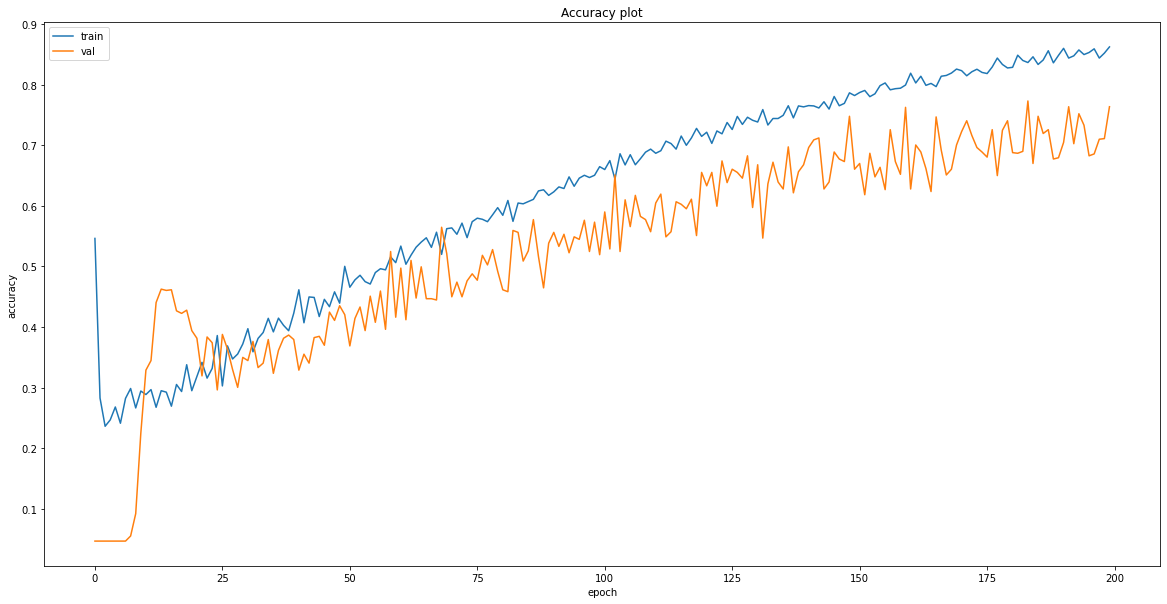

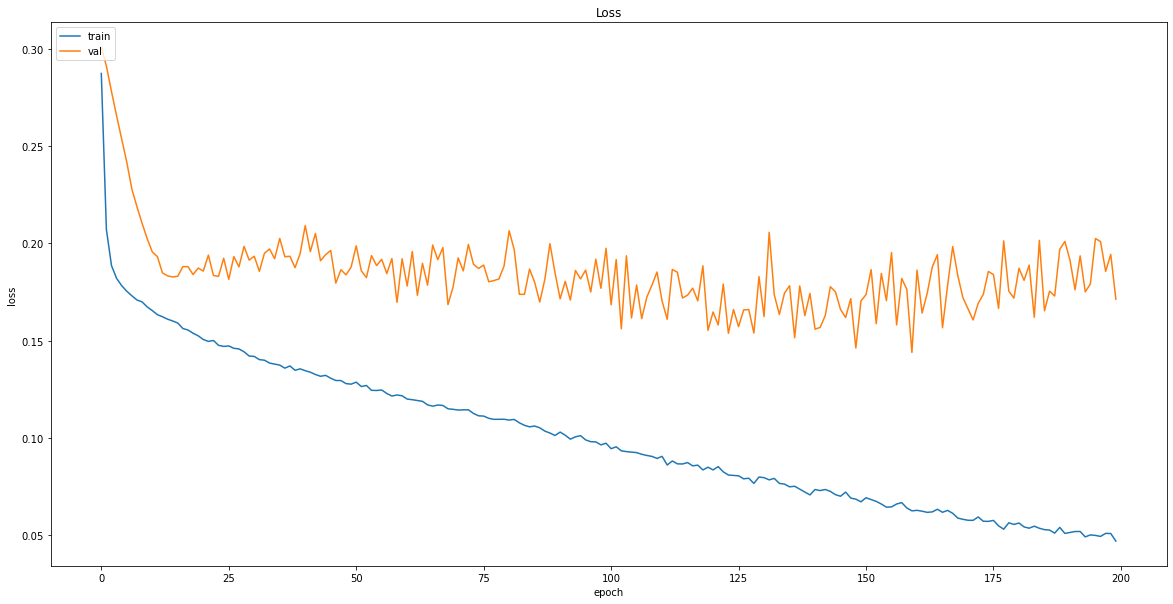

In [226]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [227]:
# Save model
model.save("models/{}".format('axl_time_series_lstm_buy_hold_sell_no_willr.model'))

INFO:tensorflow:Assets written to: models/axl_time_series_lstm_buy_hold_sell_no_willr.model\assets


### Test Performance

### non-recession

In [228]:
logger = []

In [229]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22        14.61  13.028180  -0.258404  23356600.0     2.0
2019-01-23        14.52  13.257691  -3.886001  21174700.0     2.0
2019-01-24        14.18  13.399585 -13.535906  19629300.0     2.0
2019-01-25        14.38  13.550418  -8.579880  20903300.0     2.0
2019-01-28        14.71  13.728815  -4.790414  22287500.0     2.0


In [230]:
df.drop(['willr_14'], axis='columns', inplace=True)

In [231]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(218, 15, 3)

In [232]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [233]:
model = tf.keras.models.load_model("models/axl_time_series_lstm_buy_hold_sell_no_willr.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 7ms/step - loss: 0.1744 - accuracy: 0.6789 - mean_squared_error: 6.7202 - weighted_accuracy: 0.6789 - weighted_mean_squared_error: 6.7202
Test loss: 0.1743956357240677
Test accuracy: 0.6788991093635559


In [234]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 160, 0: 21, 1: 37})

In [235]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [236]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data_test.csv")
df.set_index('Date', inplace=True)

In [237]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,14.01,14.312907,-83.060094,17347800.0,2.0,2,2
2019-02-12,14.34,14.266306,-68.852439,19189100.0,2.0,2,2
2019-02-13,14.45,14.277643,-50.819664,21493700.0,2.0,2,2
2019-02-14,14.70,14.304160,-44.808757,23008200.0,2.0,0,2
2019-02-15,16.83,14.365058,-31.147561,25735200.0,2.0,2,2


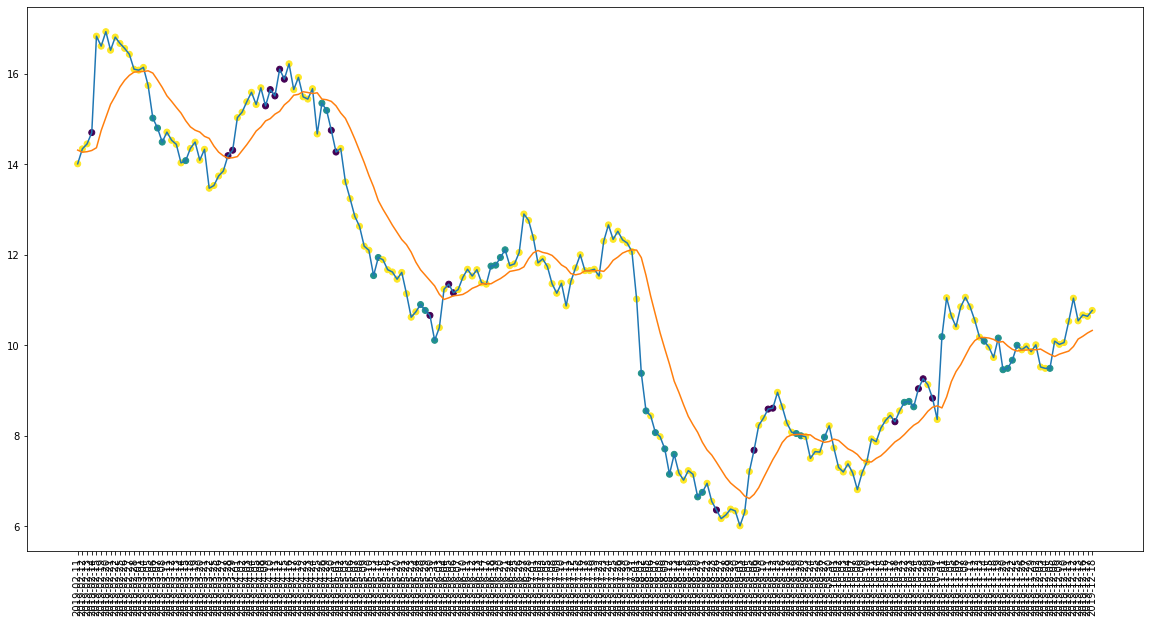

In [238]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

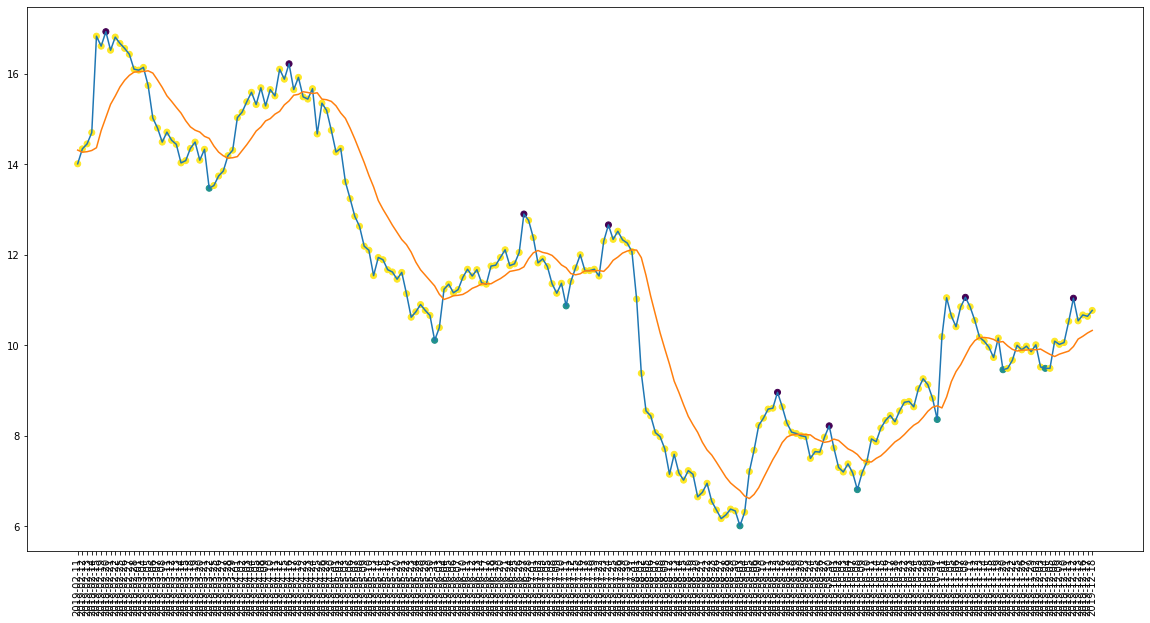

In [239]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [240]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 8
actual holds but predicted buy: 35
actual holds but predicted sell: 21
actual predicted holds: 146
Percentage buys correct: 25.0%
Percentage sells correct: 0.0%
Percentage holds correct: 72.27722772277228%
actual buys: 8
actual sells: 8
actual holds: 202


In [241]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[14.010000228881836, 14.34000015258789, 14.449999809265135, 14.699999809265135, 16.520000457763672, 16.610000610351562, 16.809999465942386, 16.829999923706055, 16.930000305175778]
[16.079999923706055, 16.100000381469727, 16.139999389648438, 16.430000305175778, 16.520000457763672, 16.559999465942386, 16.670000076293945, 16.809999465942386, 16.930000305175778]
Percentage buys correct: 32.432432432432435%
Percentage sells correct: 38.095238095238095%
Percentage holds correct: 84.27672955974843%


In [242]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $15.020000457763672
Shares owned at the moment: 663
Cash capital at the moment: $14.354480668067481


Stop Loss Activated!

Share price: $14.489999771118164
Shares owned at the moment: 0
Cash capital at the moment: $9594.80543683672


Share price: $14.489999771118164
Shares owned at the moment: 660
Cash capital at the moment: $5.106238314150687


Stop Loss Activated!

Share price: $14.029999732971193
Shares owned at the moment: 0
Cash capital at the moment: $9239.441612559796


Share price: $14.079999923706055
Shares owned at the moment: 654
Cash capital at the moment: $5.7987825932505075


Stop Loss Activated!

Share price: $13.470000267028807
Shares owned at the moment: 0
Cash capital at the moment: $8790.953161749838


Share price: $15.350000381469727
Shares owned at the moment: 571
Cash capital at the moment: $1.999605831621011


Stop Loss Activated!

Share price: $14.75
Shares owned at the moment: 0
Cash capital at the moment: $8401.088418331621


Share price: $11.539

In [243]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $7647.909066392421
profit gained: -23.520909336075793%


In [244]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.633027,33.333333333333336%,44.44444444444444%,65.5%,73.6842105263158%,60.526315789473685%,81.69014084507042%,-10.226340083160448%,-7.777238176262399%
1,0.646512,12.5%,11.11111111111111%,69.1919191919192%,40.54054054054054%,55.172413793103445%,85.23489932885906%,-50.75888178490704%,-48.34563047105195%
2,0.697248,0.0%,22.22222222222222%,74.6268656716418%,45.833333333333336%,65.51724137931035%,85.97560975609755%,0.27800619994635783%,-5.545324129943856%
3,0.651163,16.666666666666668%,30.0%,69.94818652849742%,58.064516129032256%,53.125%,85.43046357615894%,-14.343298580888566%,-7.669883276367181%
4,0.729858,0.0%,11.11111111111111%,78.8659793814433%,50.0%,55.0%,82.14285714285714%,-36.92919921341418%,-10.879329186439518%
5,0.737089,30.0%,10.0%,79.27461139896373%,45.833333333333336%,59.09090909090909%,81.92771084337349%,-16.549326210730143%,-41.56249103630067%
6,0.724771,36.36363636363637%,16.666666666666668%,76.11940298507463%,60.0%,47.05882352941177%,87.11656441717791%,18.24888354415882%,35.77290673755644%
7,0.694064,10.0%,0.0%,76.6497461928934%,50.0%,50.0%,80.0%,-41.281435080108686%,-14.13141708526613%
8,0.678899,25.0%,0.0%,72.27722772277228%,32.432432432432435%,38.095238095238095%,84.27672955974843%,-50.865857067843756%,-23.520909336075793%


### recession

In [245]:
logger = []

In [246]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2020-01-22         9.39  9.715390 -73.059349 -3592400.0     2.0
2020-01-23         9.34  9.657637 -75.342463 -4550300.0     2.0
2020-01-24         9.50  9.633386 -65.000010 -3092000.0     2.0
2020-01-27         9.31  9.583634 -66.883101 -4332600.0     2.0
2020-01-28         9.39  9.553844 -61.688301 -2300800.0     2.0


In [247]:
df.drop(['willr_14'], axis='columns', inplace=True)

In [248]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(219, 15, 3)

In [249]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [250]:
model = tf.keras.models.load_model("models/axl_time_series_lstm_buy_hold_sell_no_willr.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 6ms/step - loss: 0.1767 - accuracy: 0.7443 - mean_squared_error: 6.9241 - weighted_accuracy: 0.7443 - weighted_mean_squared_error: 6.9241
Test loss: 0.17666126787662506
Test accuracy: 0.7442922592163086


In [251]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 174, 1: 14, 0: 31})

In [252]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [253]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data_test2.csv")
df.set_index('Date', inplace=True)

In [254]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,9.84,9.643918,-57.638900,-3274300.0,2.0,2,2
2020-02-12,10.34,9.674085,-36.805548,-1876100.0,0.0,2,0
2020-02-13,10.22,9.776533,-16.568036,-291400.0,2.0,2,2
2020-02-14,8.77,9.844759,-23.668622,-1567700.0,2.0,2,2
2020-02-18,8.27,9.679411,-90.686248,-6644000.0,2.0,2,2


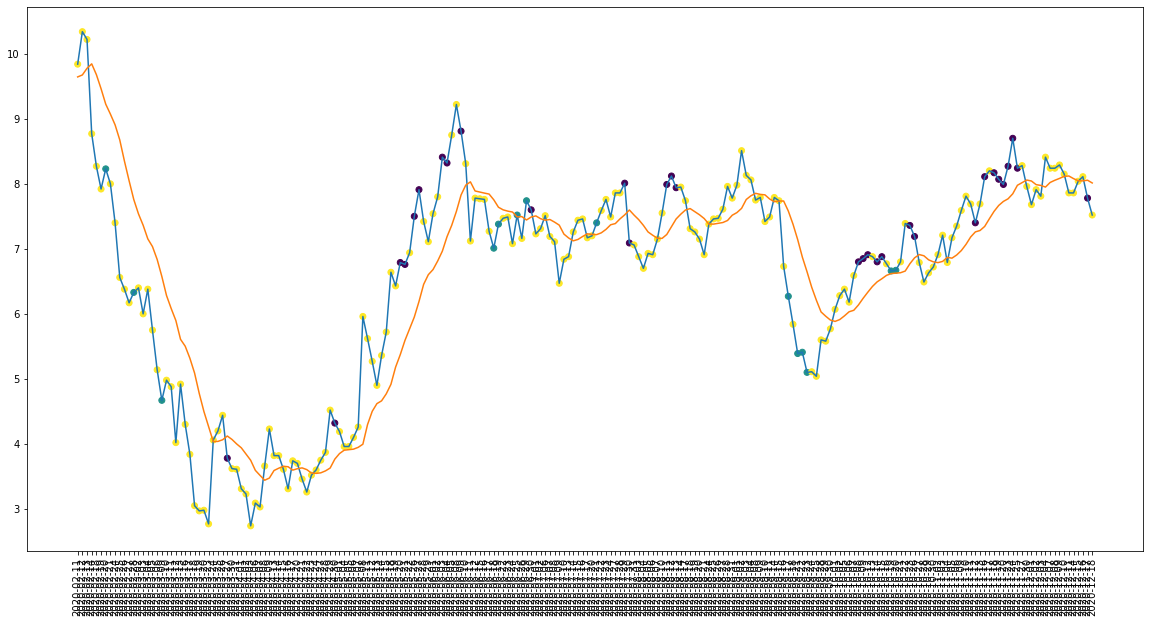

In [255]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

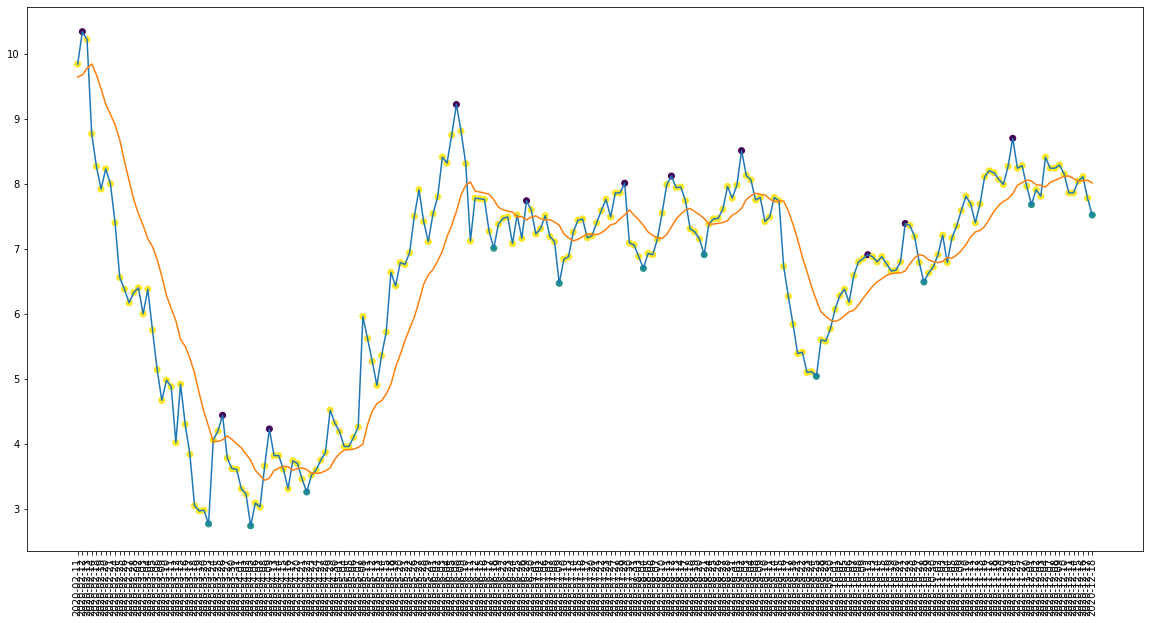

In [256]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [257]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 10
actual sells but predicted buy: 1
actual predicted sells: 4
actual sells but predicted hold: 6
actual holds but predicted buy: 12
actual holds but predicted sell: 27
actual predicted holds: 158
Percentage buys correct: 9.090909090909092%
Percentage sells correct: 36.36363636363637%
Percentage holds correct: 80.20304568527919%
actual buys: 11
actual sells: 11
actual holds: 197


In [258]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[7.400000095367432, 7.920000076293945, 8.0, 8.229999542236326, 8.270000457763674, 8.770000457763674, 9.84000015258789, 10.220000267028807, 10.34000015258789]
[6.0, 6.170000076293945, 6.329999923706055, 6.380000114440918, 6.4000000953674325, 6.559999942779541, 7.400000095367432, 8.0, 8.229999542236326]
Percentage buys correct: 64.28571428571429%
Percentage sells correct: 74.19354838709677%
Percentage holds correct: 86.1271676300578%


In [259]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $8.229999542236326
Shares owned at the moment: 1211
Cash capital at the moment: $6.062598376274764


Stop Loss Activated!

Share price: $8.0
Shares owned at the moment: 0
Cash capital at the moment: $9667.420598376275


Share price: $6.329999923706055
Shares owned at the moment: 1523
Cash capital at the moment: $0.3190923914917221


Stop Loss Activated!

Share price: $6.0
Shares owned at the moment: 0
Cash capital at the moment: $9113.18959239149


Share price: $4.670000076293945
Shares owned at the moment: 1946
Cash capital at the moment: $0.37793851518654265


Stop Loss Activated!

Share price: $4.019999980926514
Shares owned at the moment: 0
Cash capital at the moment: $7801.784871500254


Share price: $7.010000228881836
Shares owned at the moment: 1109
Cash capital at the moment: $6.315869472265149


Price increase from previously bought: 8.119215047162264%
Share price: $7.599999904632567
Shares owned at the moment: 0
Cash capital at the moment: $8411.537664000629


Sh

In [260]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $7601.479205735086
profit gained: -23.98520794264914%


In [261]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.633027,33.333333333333336%,44.44444444444444%,65.5%,73.6842105263158%,60.526315789473685%,81.69014084507042%,-10.226340083160448%,-7.777238176262399%
1,0.646512,12.5%,11.11111111111111%,69.1919191919192%,40.54054054054054%,55.172413793103445%,85.23489932885906%,-50.75888178490704%,-48.34563047105195%
2,0.697248,0.0%,22.22222222222222%,74.6268656716418%,45.833333333333336%,65.51724137931035%,85.97560975609755%,0.27800619994635783%,-5.545324129943856%
3,0.651163,16.666666666666668%,30.0%,69.94818652849742%,58.064516129032256%,53.125%,85.43046357615894%,-14.343298580888566%,-7.669883276367181%
4,0.729858,0.0%,11.11111111111111%,78.8659793814433%,50.0%,55.0%,82.14285714285714%,-36.92919921341418%,-10.879329186439518%
5,0.737089,30.0%,10.0%,79.27461139896373%,45.833333333333336%,59.09090909090909%,81.92771084337349%,-16.549326210730143%,-41.56249103630067%
6,0.724771,36.36363636363637%,16.666666666666668%,76.11940298507463%,60.0%,47.05882352941177%,87.11656441717791%,18.24888354415882%,35.77290673755644%
7,0.694064,10.0%,0.0%,76.6497461928934%,50.0%,50.0%,80.0%,-41.281435080108686%,-14.13141708526613%
8,0.678899,25.0%,0.0%,72.27722772277228%,32.432432432432435%,38.095238095238095%,84.27672955974843%,-50.865857067843756%,-23.520909336075793%
9,0.744292,9.090909090909092%,36.36363636363637%,80.20304568527919%,64.28571428571429%,74.19354838709677%,86.1271676300578%,15.020568705236856%,-23.98520794264914%


In [262]:
experiment

'No willr LSTM Time Series - cyclic'

In [263]:
log.to_csv('{}.csv'.format(experiment))